# Demonstration of InvGP models
#### 2 vs 3, images are rotated randomly $-180\sim 180$ degrees
#### Train models for 10000 iterations for demo

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
import numpy.random as rnd
import tensorflow_addons as tfa
from gpflow.utilities import set_trainable
from gpflow.utilities import print_summary
import time
import Original
import Transformed
gpflow.config.set_default_jitter(1e-5)

# Creating rotated MNIST 2 vs 3

In [2]:
def load_mnist(digits=[2, 3]):
    mnist = tf.keras.datasets.mnist.load_data()
    full_X_train, full_X_test = [x[0].reshape(-1, 28 * 28).astype(gpflow.config.default_float()) / 255.0
                                 for x in mnist]
    full_Y_train, full_Y_test = [x[1].reshape(-1, 1).astype(gpflow.config.default_int())
                                 for x in mnist]
    select_train = np.isin(full_Y_train[:, 0], digits)
    X, Y = [x[select_train, :] for x in [full_X_train, full_Y_train]]
    select_test = np.isin(full_Y_test[:, 0], digits)
    Xt, Yt = [x[select_test, :] for x in [full_X_test, full_Y_test]]
    return (X, Y), (Xt, Yt)

(X_train,Y_train),(X_test,Y_test)=load_mnist()
np.random.seed(1)
random_perm = np.random.permutation(len(X_train))
X = X_train[random_perm[:5000], :]
Y = (Y_train[random_perm[:5000], :] == 2.0).astype('float') * 2.0 - 1.0
Xt = X_train[random_perm[5000:6000], :]
Yt = (Y_train[random_perm[5000:6000], :] == 2.0).astype('float') * 2.0 - 1.0

In [3]:
from Original.kernels.image_transforms import rotate_img_angles, rotate_img_angles_stn, apply_stn_batch, _stn_theta_vec, \
    apply_stn_batch_colour
X2=[]
for i in range(X.shape[0]):
    angle=-360*np.random.rand((1))+180
    Ximg=np.reshape(X[i], [-1, 28, 28])
    Ximg2=rotate_img_angles(Ximg, angle, "Nearest")
    X2=np.append(X2,Ximg2.numpy().reshape(-1, X.shape[1]))
X2=X2.reshape(-1,X.shape[1])
print(X2.shape)
Y2=Y
Xt2=[]
for i in range(Xt.shape[0]):
    angle=-360*np.random.rand((1))+180
    Xtimg=np.reshape(Xt[i], [-1, 28, 28])
    Xtimg2=rotate_img_angles(Xtimg, angle, "Nearest")
    Xt2=np.append(Xt2,Xtimg2.numpy().reshape(-1, Xt.shape[1]))
Xt2=Xt2.reshape(-1,Xt.shape[1])
print(Xt2.shape)
Yt2=Yt

(5000, 784)
(1000, 784)


# Train Original model

In [10]:
import Original as invgp
from Original.models.SVGP import SVGP
from Original.inducing_variables.invariant_convolution_domain import StochasticConvolvedInducingPoints
from Original.inducing_variables.invariant_convolution_domain import ConvolvedInducingPoints

#Set inducing points
M=300
N=len(X)
np.random.seed(1)
Z = X2[rnd.permutation(len(X))[:M], :]
inducing_variables = StochasticConvolvedInducingPoints(Z)

#set kernel
"""
For 90 degree intervals, use Rot90()
When learning invariance, set use_stn=True
"""
k = invgp.kernels.StochasticInvariant(gpflow.kernels.SquaredExponential(),
                                  invgp.kernels.orbits.ImageRotation(minibatch_size=15,use_stn=False,angle=179))

#define model
m1 = SVGP(k,gpflow.likelihoods.Gaussian(),inducing_variable=inducing_variables,num_data=N,num_latent_gps=1,whiten=True)
m1.kernel.basekern.lengthscales.assign(5)

#define minibatch
minibatch_size=30
train_dataset = tf.data.Dataset.from_tensor_slices((X2, Y2))
train_dataset = train_dataset.shuffle(N).batch(minibatch_size)
train_iter=iter(train_dataset.repeat())
training_loss = m1.training_loss_closure(train_iter, compile=True)


# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, m1.trainable_variables)

logf1=[ ]
acc1=[ ]


for step in range(10000):
    optimization_step()
    minibatch_elbo = -training_loss().numpy()
    
    logf1.append(minibatch_elbo)

    print('Step: %s, Mini batch elbo: %s \n' % (step, minibatch_elbo))

    if step%100==99:
        err = (1.0 - ((m1.predict_f(Xt2)[0] > 0.0) == (Yt2 > 0.0)).numpy().mean()) * 100
        print(f"err: {err:.2f}")
        acc1.append(err)


stochastic_inv_conditional
sub conditional
Step: 0, Mini batch elbo: -7468.794068440936 

Step: 1, Mini batch elbo: -7453.290995364478 

Step: 2, Mini batch elbo: -7398.620914490117 

Step: 3, Mini batch elbo: -7335.990993013884 

Step: 4, Mini batch elbo: -7303.7849885930145 

Step: 5, Mini batch elbo: -7354.173800821682 

Step: 6, Mini batch elbo: -7275.930094739373 

Step: 7, Mini batch elbo: -7370.443044260683 

Step: 8, Mini batch elbo: -7307.568549449952 

Step: 9, Mini batch elbo: -7306.4180868455815 

Step: 10, Mini batch elbo: -7266.522666702243 

Step: 11, Mini batch elbo: -7191.374011153751 

Step: 12, Mini batch elbo: -7241.417378642023 

Step: 13, Mini batch elbo: -7221.234613615711 

Step: 14, Mini batch elbo: -7239.376731474938 

Step: 15, Mini batch elbo: -7240.170248688511 

Step: 16, Mini batch elbo: -7214.036420228691 

Step: 17, Mini batch elbo: -7147.752459376884 

Step: 18, Mini batch elbo: -7148.23330201124 

Step: 19, Mini batch elbo: -7198.378850413934 

Step: 

Step: 169, Mini batch elbo: -6781.965087045806 

Step: 170, Mini batch elbo: -6635.755973201843 

Step: 171, Mini batch elbo: -6705.404252819988 

Step: 172, Mini batch elbo: -6949.000500254559 

Step: 173, Mini batch elbo: -6710.367835144919 

Step: 174, Mini batch elbo: -6680.915064286893 

Step: 175, Mini batch elbo: -6687.668542974439 

Step: 176, Mini batch elbo: -6528.232369885729 

Step: 177, Mini batch elbo: -6752.04406880878 

Step: 178, Mini batch elbo: -6530.617246020102 

Step: 179, Mini batch elbo: -6562.255969464202 

Step: 180, Mini batch elbo: -6630.012875287734 

Step: 181, Mini batch elbo: -6706.287042763857 

Step: 182, Mini batch elbo: -6689.131967774628 

Step: 183, Mini batch elbo: -6707.142016169424 

Step: 184, Mini batch elbo: -6511.63392712849 

Step: 185, Mini batch elbo: -6725.487348957238 

Step: 186, Mini batch elbo: -6773.187931170715 

Step: 187, Mini batch elbo: -6752.361094226879 

Step: 188, Mini batch elbo: -6527.853914220468 

Step: 189, Mini batch 

Step: 336, Mini batch elbo: -6153.659061939025 

Step: 337, Mini batch elbo: -6026.167292651773 

Step: 338, Mini batch elbo: -6099.289600562319 

Step: 339, Mini batch elbo: -6180.707267061819 

Step: 340, Mini batch elbo: -6428.215920655344 

Step: 341, Mini batch elbo: -5818.2020601920285 

Step: 342, Mini batch elbo: -6062.997635558571 

Step: 343, Mini batch elbo: -5657.374847655998 

Step: 344, Mini batch elbo: -6157.267787526239 

Step: 345, Mini batch elbo: -6247.743555837338 

Step: 346, Mini batch elbo: -6381.413991108166 

Step: 347, Mini batch elbo: -6723.842712130841 

Step: 348, Mini batch elbo: -6234.649173627616 

Step: 349, Mini batch elbo: -5623.906640529564 

Step: 350, Mini batch elbo: -6385.506969346511 

Step: 351, Mini batch elbo: -6246.624578785432 

Step: 352, Mini batch elbo: -6433.694607738745 

Step: 353, Mini batch elbo: -5869.2351367664105 

Step: 354, Mini batch elbo: -5872.973702655294 

Step: 355, Mini batch elbo: -5768.976417397442 

Step: 356, Mini ba

Step: 502, Mini batch elbo: -5497.789165943914 

Step: 503, Mini batch elbo: -5713.446442019907 

Step: 504, Mini batch elbo: -5651.788523656608 

Step: 505, Mini batch elbo: -5922.149884790122 

Step: 506, Mini batch elbo: -5697.538890916433 

Step: 507, Mini batch elbo: -5637.329480373324 

Step: 508, Mini batch elbo: -5916.152626702193 

Step: 509, Mini batch elbo: -5768.483047793171 

Step: 510, Mini batch elbo: -5198.388361296 

Step: 511, Mini batch elbo: -5323.962418429145 

Step: 512, Mini batch elbo: -5368.613788012685 

Step: 513, Mini batch elbo: -5647.847343595421 

Step: 514, Mini batch elbo: -5885.156265498401 

Step: 515, Mini batch elbo: -5697.629620043273 

Step: 516, Mini batch elbo: -5994.621935783842 

Step: 517, Mini batch elbo: -5692.598697975746 

Step: 518, Mini batch elbo: -5289.305692763311 

Step: 519, Mini batch elbo: -6025.931385887979 

Step: 520, Mini batch elbo: -5598.965465037137 

Step: 521, Mini batch elbo: -5473.818117740066 

Step: 522, Mini batch e

Step: 669, Mini batch elbo: -4524.800160927916 

Step: 670, Mini batch elbo: -5205.527514546671 

Step: 671, Mini batch elbo: -4998.828905710315 

Step: 672, Mini batch elbo: -5882.871804428038 

Step: 673, Mini batch elbo: -5643.46463925269 

Step: 674, Mini batch elbo: -5482.227428263125 

Step: 675, Mini batch elbo: -5016.535428843404 

Step: 676, Mini batch elbo: -5091.499633730064 

Step: 677, Mini batch elbo: -4871.483730866201 

Step: 678, Mini batch elbo: -5232.620951964387 

Step: 679, Mini batch elbo: -5271.746532041976 

Step: 680, Mini batch elbo: -4547.095709196807 

Step: 681, Mini batch elbo: -5382.589654087683 

Step: 682, Mini batch elbo: -5021.360011284568 

Step: 683, Mini batch elbo: -5095.750233360539 

Step: 684, Mini batch elbo: -5487.438654676227 

Step: 685, Mini batch elbo: -4952.15629985879 

Step: 686, Mini batch elbo: -4966.69712139998 

Step: 687, Mini batch elbo: -4612.807270059431 

Step: 688, Mini batch elbo: -4659.636355326312 

Step: 689, Mini batch e

Step: 836, Mini batch elbo: -4927.139356773389 

Step: 837, Mini batch elbo: -4999.405804454036 

Step: 838, Mini batch elbo: -5332.031390839659 

Step: 839, Mini batch elbo: -5150.391362265887 

Step: 840, Mini batch elbo: -4973.847701805709 

Step: 841, Mini batch elbo: -5045.2179696830335 

Step: 842, Mini batch elbo: -5223.1035021017 

Step: 843, Mini batch elbo: -5186.503355627767 

Step: 844, Mini batch elbo: -4713.01308603157 

Step: 845, Mini batch elbo: -4838.164019905423 

Step: 846, Mini batch elbo: -4316.952580600089 

Step: 847, Mini batch elbo: -5175.795047236667 

Step: 848, Mini batch elbo: -4165.509468565451 

Step: 849, Mini batch elbo: -5027.51379087736 

Step: 850, Mini batch elbo: -4705.803076006723 

Step: 851, Mini batch elbo: -5099.088412599169 

Step: 852, Mini batch elbo: -5107.551354903622 

Step: 853, Mini batch elbo: -4487.424819778504 

Step: 854, Mini batch elbo: -4769.685795524473 

Step: 855, Mini batch elbo: -4930.580971410846 

Step: 856, Mini batch e

Step: 1003, Mini batch elbo: -4365.269491545778 

Step: 1004, Mini batch elbo: -3854.321739857909 

Step: 1005, Mini batch elbo: -4343.051559980323 

Step: 1006, Mini batch elbo: -4502.581792970996 

Step: 1007, Mini batch elbo: -4817.162445781287 

Step: 1008, Mini batch elbo: -3599.872820949366 

Step: 1009, Mini batch elbo: -4609.93093711903 

Step: 1010, Mini batch elbo: -5170.971428808002 

Step: 1011, Mini batch elbo: -4714.241271574868 

Step: 1012, Mini batch elbo: -4735.777961203318 

Step: 1013, Mini batch elbo: -5149.840407452282 

Step: 1014, Mini batch elbo: -5301.8078996644645 

Step: 1015, Mini batch elbo: -5629.319050280557 

Step: 1016, Mini batch elbo: -3966.7650524551177 

Step: 1017, Mini batch elbo: -5889.893219165073 

Step: 1018, Mini batch elbo: -4429.2643288264435 

Step: 1019, Mini batch elbo: -5150.792912038836 

Step: 1020, Mini batch elbo: -3811.2384238060677 

Step: 1021, Mini batch elbo: -4779.297640328306 

Step: 1022, Mini batch elbo: -4833.730088246185

Step: 1166, Mini batch elbo: -4227.239470543614 

Step: 1167, Mini batch elbo: -4182.843403205056 

Step: 1168, Mini batch elbo: -4365.05794774919 

Step: 1169, Mini batch elbo: -4024.9969487868 

Step: 1170, Mini batch elbo: -4053.956688115022 

Step: 1171, Mini batch elbo: -3720.6875560415715 

Step: 1172, Mini batch elbo: -4246.134328964946 

Step: 1173, Mini batch elbo: -4500.9638104836595 

Step: 1174, Mini batch elbo: -3689.1589131572528 

Step: 1175, Mini batch elbo: -4508.376296679971 

Step: 1176, Mini batch elbo: -5034.034774384653 

Step: 1177, Mini batch elbo: -3757.554228987712 

Step: 1178, Mini batch elbo: -4579.127441955823 

Step: 1179, Mini batch elbo: -4787.760200137038 

Step: 1180, Mini batch elbo: -4900.010974902846 

Step: 1181, Mini batch elbo: -4449.263408456788 

Step: 1182, Mini batch elbo: -3426.79631524829 

Step: 1183, Mini batch elbo: -4308.02733355361 

Step: 1184, Mini batch elbo: -4737.41372574926 

Step: 1185, Mini batch elbo: -4761.128146186722 

Ste

Step: 1330, Mini batch elbo: -3861.059636766262 

Step: 1331, Mini batch elbo: -4432.614771599343 

Step: 1332, Mini batch elbo: -5722.487233608753 

Step: 1333, Mini batch elbo: -3396.6343387614193 

Step: 1334, Mini batch elbo: -5057.50152256525 

Step: 1335, Mini batch elbo: -3294.7873390581503 

Step: 1336, Mini batch elbo: -3629.5087564701835 

Step: 1337, Mini batch elbo: -4634.607557287481 

Step: 1338, Mini batch elbo: -4861.776350430712 

Step: 1339, Mini batch elbo: -3859.509403651549 

Step: 1340, Mini batch elbo: -4529.877228613893 

Step: 1341, Mini batch elbo: -3926.6267515351533 

Step: 1342, Mini batch elbo: -4036.1642442919306 

Step: 1343, Mini batch elbo: -4995.129440947369 

Step: 1344, Mini batch elbo: -3935.8917645011034 

Step: 1345, Mini batch elbo: -4467.430059440737 

Step: 1346, Mini batch elbo: -4651.785979412249 

Step: 1347, Mini batch elbo: -4026.0013309523874 

Step: 1348, Mini batch elbo: -5247.621866908607 

Step: 1349, Mini batch elbo: -3646.912205378

Step: 1493, Mini batch elbo: -3826.790135333786 

Step: 1494, Mini batch elbo: -4660.561604050238 

Step: 1495, Mini batch elbo: -3979.4679408943375 

Step: 1496, Mini batch elbo: -4788.589580183775 

Step: 1497, Mini batch elbo: -3365.9824248856617 

Step: 1498, Mini batch elbo: -3558.3763084252014 

Step: 1499, Mini batch elbo: -3305.0906957798447 

stochastic_inv_conditional
sub conditional
err: 4.20
Step: 1500, Mini batch elbo: -4403.106222268453 

Step: 1501, Mini batch elbo: -4189.90617688236 

Step: 1502, Mini batch elbo: -3647.1622607371196 

Step: 1503, Mini batch elbo: -4613.273396659935 

Step: 1504, Mini batch elbo: -3509.721966057141 

Step: 1505, Mini batch elbo: -3374.8895400206798 

Step: 1506, Mini batch elbo: -4084.132340736475 

Step: 1507, Mini batch elbo: -3902.9860211144132 

Step: 1508, Mini batch elbo: -4473.804372679173 

Step: 1509, Mini batch elbo: -3743.0307456174587 

Step: 1510, Mini batch elbo: -4364.629926247398 

Step: 1511, Mini batch elbo: -5364.68261

Step: 1656, Mini batch elbo: -3409.84255192109 

Step: 1657, Mini batch elbo: -3554.5499010849826 

Step: 1658, Mini batch elbo: -3593.547822603725 

Step: 1659, Mini batch elbo: -4445.7948686575355 

Step: 1660, Mini batch elbo: -4617.720160135106 

Step: 1661, Mini batch elbo: -3614.686657685113 

Step: 1662, Mini batch elbo: -4075.7729284969732 

Step: 1663, Mini batch elbo: -4793.662256212229 

Step: 1664, Mini batch elbo: -3777.6516351180935 

Step: 1665, Mini batch elbo: -4487.961226026814 

Step: 1666, Mini batch elbo: -4907.335672190433 

Step: 1667, Mini batch elbo: -3782.84717435978 

Step: 1668, Mini batch elbo: -4808.315985839194 

Step: 1669, Mini batch elbo: -3166.9683481682946 

Step: 1670, Mini batch elbo: -2553.729030639005 

Step: 1671, Mini batch elbo: -3225.79163399257 

Step: 1672, Mini batch elbo: -4102.763730771044 

Step: 1673, Mini batch elbo: -4166.129875948162 

Step: 1674, Mini batch elbo: -3129.5590162637586 

Step: 1675, Mini batch elbo: -3684.639882286151

Step: 1818, Mini batch elbo: -3264.5277722303936 

Step: 1819, Mini batch elbo: -3817.6105666934077 

Step: 1820, Mini batch elbo: -2717.862387795065 

Step: 1821, Mini batch elbo: -3242.561138529398 

Step: 1822, Mini batch elbo: -3823.029508615587 

Step: 1823, Mini batch elbo: -4391.210714312767 

Step: 1824, Mini batch elbo: -4735.925919202027 

Step: 1825, Mini batch elbo: -3157.6366999763145 

Step: 1826, Mini batch elbo: -5239.109603541088 

Step: 1827, Mini batch elbo: -2944.1635107258066 

Step: 1828, Mini batch elbo: -4041.1937932183137 

Step: 1829, Mini batch elbo: -3791.3439289538974 

Step: 1830, Mini batch elbo: -4050.275579479402 

Step: 1831, Mini batch elbo: -4361.376227525393 

Step: 1832, Mini batch elbo: -3183.0003190819025 

Step: 1833, Mini batch elbo: -4022.856622039971 

Step: 1834, Mini batch elbo: -4307.634752942233 

Step: 1835, Mini batch elbo: -3060.530266593531 

Step: 1836, Mini batch elbo: -3838.842581713227 

Step: 1837, Mini batch elbo: -4182.90196059

Step: 1981, Mini batch elbo: -3748.4869504624285 

Step: 1982, Mini batch elbo: -5156.725197379686 

Step: 1983, Mini batch elbo: -4314.239368526695 

Step: 1984, Mini batch elbo: -3109.7935992670045 

Step: 1985, Mini batch elbo: -3400.0253383598647 

Step: 1986, Mini batch elbo: -2938.89908844455 

Step: 1987, Mini batch elbo: -3671.021029581556 

Step: 1988, Mini batch elbo: -3248.150048379624 

Step: 1989, Mini batch elbo: -4556.706223003352 

Step: 1990, Mini batch elbo: -4400.992149983701 

Step: 1991, Mini batch elbo: -3758.090779958668 

Step: 1992, Mini batch elbo: -3768.510001483891 

Step: 1993, Mini batch elbo: -3980.9486219425335 

Step: 1994, Mini batch elbo: -5171.649227038998 

Step: 1995, Mini batch elbo: -3978.009148299666 

Step: 1996, Mini batch elbo: -3515.7442819654675 

Step: 1997, Mini batch elbo: -3300.965983913922 

Step: 1998, Mini batch elbo: -5692.676612586654 

Step: 1999, Mini batch elbo: -4568.447148354541 

stochastic_inv_conditional
sub conditional
err

Step: 2142, Mini batch elbo: -4882.814744607774 

Step: 2143, Mini batch elbo: -4571.956286290874 

Step: 2144, Mini batch elbo: -3098.653396928304 

Step: 2145, Mini batch elbo: -3201.945260763837 

Step: 2146, Mini batch elbo: -2892.40764823647 

Step: 2147, Mini batch elbo: -3285.079973649131 

Step: 2148, Mini batch elbo: -4691.691681467393 

Step: 2149, Mini batch elbo: -5099.078848033208 

Step: 2150, Mini batch elbo: -2826.231445512686 

Step: 2151, Mini batch elbo: -3532.7635935394424 

Step: 2152, Mini batch elbo: -2864.151144731465 

Step: 2153, Mini batch elbo: -3937.2686046053864 

Step: 2154, Mini batch elbo: -4533.4565736686745 

Step: 2155, Mini batch elbo: -3063.2266682041354 

Step: 2156, Mini batch elbo: -4579.58021296188 

Step: 2157, Mini batch elbo: -4283.203089600082 

Step: 2158, Mini batch elbo: -3964.7619047649487 

Step: 2159, Mini batch elbo: -2877.4255382470824 

Step: 2160, Mini batch elbo: -4675.463340048608 

Step: 2161, Mini batch elbo: -4630.15536414716

Step: 2303, Mini batch elbo: -4614.995744412263 

Step: 2304, Mini batch elbo: -3654.83748648363 

Step: 2305, Mini batch elbo: -4232.424551152636 

Step: 2306, Mini batch elbo: -2974.5573957472225 

Step: 2307, Mini batch elbo: -4642.072387870326 

Step: 2308, Mini batch elbo: -2833.984991985702 

Step: 2309, Mini batch elbo: -3010.0615722435705 

Step: 2310, Mini batch elbo: -2834.4241972943482 

Step: 2311, Mini batch elbo: -4148.980845288204 

Step: 2312, Mini batch elbo: -4331.11312736909 

Step: 2313, Mini batch elbo: -3838.026067035744 

Step: 2314, Mini batch elbo: -3608.789618283324 

Step: 2315, Mini batch elbo: -4259.6417276825005 

Step: 2316, Mini batch elbo: -4230.124428612033 

Step: 2317, Mini batch elbo: -4335.828220241626 

Step: 2318, Mini batch elbo: -2951.721826063746 

Step: 2319, Mini batch elbo: -3808.8195013929712 

Step: 2320, Mini batch elbo: -3817.816301572877 

Step: 2321, Mini batch elbo: -5475.708234915521 

Step: 2322, Mini batch elbo: -4604.502322344292

Step: 2466, Mini batch elbo: -2826.5087805040844 

Step: 2467, Mini batch elbo: -3003.704645345943 

Step: 2468, Mini batch elbo: -4160.057569240521 

Step: 2469, Mini batch elbo: -3732.8029462298937 

Step: 2470, Mini batch elbo: -2496.3796314905467 

Step: 2471, Mini batch elbo: -4457.515618737643 

Step: 2472, Mini batch elbo: -4537.395211118575 

Step: 2473, Mini batch elbo: -3286.0012127249743 

Step: 2474, Mini batch elbo: -5032.211993854932 

Step: 2475, Mini batch elbo: -3735.836654754864 

Step: 2476, Mini batch elbo: -2753.289469677587 

Step: 2477, Mini batch elbo: -3214.5260266018554 

Step: 2478, Mini batch elbo: -3608.095345762919 

Step: 2479, Mini batch elbo: -4957.77150468106 

Step: 2480, Mini batch elbo: -3147.4291339187225 

Step: 2481, Mini batch elbo: -3353.9529482673597 

Step: 2482, Mini batch elbo: -5576.200303056195 

Step: 2483, Mini batch elbo: -2999.110795092665 

Step: 2484, Mini batch elbo: -2964.2664811256805 

Step: 2485, Mini batch elbo: -4512.39251826

Step: 2627, Mini batch elbo: -3786.3271931913937 

Step: 2628, Mini batch elbo: -3281.781346301459 

Step: 2629, Mini batch elbo: -4022.87603533889 

Step: 2630, Mini batch elbo: -2612.633616008235 

Step: 2631, Mini batch elbo: -2580.852130451908 

Step: 2632, Mini batch elbo: -2925.4517834511075 

Step: 2633, Mini batch elbo: -3564.27002956185 

Step: 2634, Mini batch elbo: -4075.7993180837734 

Step: 2635, Mini batch elbo: -4096.482769747521 

Step: 2636, Mini batch elbo: -3548.6705565278558 

Step: 2637, Mini batch elbo: -3183.902609618305 

Step: 2638, Mini batch elbo: -3490.804087811489 

Step: 2639, Mini batch elbo: -3451.359424330809 

Step: 2640, Mini batch elbo: -4646.848249051788 

Step: 2641, Mini batch elbo: -3005.3806678228425 

Step: 2642, Mini batch elbo: -2557.2261237405137 

Step: 2643, Mini batch elbo: -3638.722850702193 

Step: 2644, Mini batch elbo: -4224.874089872052 

Step: 2645, Mini batch elbo: -5018.616929430333 

Step: 2646, Mini batch elbo: -3230.14532221645

Step: 2790, Mini batch elbo: -3291.6049323503375 

Step: 2791, Mini batch elbo: -3740.814215568187 

Step: 2792, Mini batch elbo: -3387.1897123846893 

Step: 2793, Mini batch elbo: -3332.730363467673 

Step: 2794, Mini batch elbo: -2974.519185971083 

Step: 2795, Mini batch elbo: -3586.3244378375557 

Step: 2796, Mini batch elbo: -4456.631565064295 

Step: 2797, Mini batch elbo: -3752.171981848453 

Step: 2798, Mini batch elbo: -3569.3730989611386 

Step: 2799, Mini batch elbo: -3651.2549380164264 

stochastic_inv_conditional
sub conditional
err: 3.00
Step: 2800, Mini batch elbo: -3669.553887152915 

Step: 2801, Mini batch elbo: -4246.550944485723 

Step: 2802, Mini batch elbo: -2991.48614355696 

Step: 2803, Mini batch elbo: -3084.905696000337 

Step: 2804, Mini batch elbo: -3062.245939717144 

Step: 2805, Mini batch elbo: -3150.1583986127703 

Step: 2806, Mini batch elbo: -2369.8782797262943 

Step: 2807, Mini batch elbo: -4090.495431609989 

Step: 2808, Mini batch elbo: -3911.089770

Step: 2953, Mini batch elbo: -4252.524227726498 

Step: 2954, Mini batch elbo: -3281.103104524762 

Step: 2955, Mini batch elbo: -2574.9359083435324 

Step: 2956, Mini batch elbo: -3458.959700115063 

Step: 2957, Mini batch elbo: -3955.126677627979 

Step: 2958, Mini batch elbo: -4759.208977523051 

Step: 2959, Mini batch elbo: -3198.4628300721233 

Step: 2960, Mini batch elbo: -3013.6271938356103 

Step: 2961, Mini batch elbo: -4138.317147380224 

Step: 2962, Mini batch elbo: -4134.2378655130215 

Step: 2963, Mini batch elbo: -3290.5219535464685 

Step: 2964, Mini batch elbo: -3172.569668315352 

Step: 2965, Mini batch elbo: -3082.270350597063 

Step: 2966, Mini batch elbo: -3033.4876838420387 

Step: 2967, Mini batch elbo: -4344.8468301298735 

Step: 2968, Mini batch elbo: -2994.5315753922737 

Step: 2969, Mini batch elbo: -3516.141407634098 

Step: 2970, Mini batch elbo: -4632.59616073814 

Step: 2971, Mini batch elbo: -4026.64264321194 

Step: 2972, Mini batch elbo: -3090.638643159

Step: 3115, Mini batch elbo: -3413.1632560768007 

Step: 3116, Mini batch elbo: -4446.245762477665 

Step: 3117, Mini batch elbo: -3409.257947895298 

Step: 3118, Mini batch elbo: -2611.3374798462487 

Step: 3119, Mini batch elbo: -3822.4345025799585 

Step: 3120, Mini batch elbo: -3156.0806130981564 

Step: 3121, Mini batch elbo: -3635.9748901330995 

Step: 3122, Mini batch elbo: -3622.2374329935665 

Step: 3123, Mini batch elbo: -3412.954749896678 

Step: 3124, Mini batch elbo: -3656.1847709631024 

Step: 3125, Mini batch elbo: -2594.285787966398 

Step: 3126, Mini batch elbo: -2639.317722087535 

Step: 3127, Mini batch elbo: -3648.489332094564 

Step: 3128, Mini batch elbo: -3292.25435763881 

Step: 3129, Mini batch elbo: -4175.400758780759 

Step: 3130, Mini batch elbo: -3196.6112444342566 

Step: 3131, Mini batch elbo: -2595.3696212203267 

Step: 3132, Mini batch elbo: -3089.1149857542823 

Step: 3133, Mini batch elbo: -4910.5110800057955 

Step: 3134, Mini batch elbo: -4770.58136

Step: 3278, Mini batch elbo: -4855.099134543816 

Step: 3279, Mini batch elbo: -3188.057394389145 

Step: 3280, Mini batch elbo: -3885.8616983149595 

Step: 3281, Mini batch elbo: -3512.214739898303 

Step: 3282, Mini batch elbo: -2753.839146183914 

Step: 3283, Mini batch elbo: -3254.6389047052958 

Step: 3284, Mini batch elbo: -3457.7352622725452 

Step: 3285, Mini batch elbo: -2647.301312111347 

Step: 3286, Mini batch elbo: -2522.640959234047 

Step: 3287, Mini batch elbo: -3890.3504037297384 

Step: 3288, Mini batch elbo: -3870.7512108258193 

Step: 3289, Mini batch elbo: -4106.185760115209 

Step: 3290, Mini batch elbo: -3850.111017937728 

Step: 3291, Mini batch elbo: -3070.003737648152 

Step: 3292, Mini batch elbo: -5111.0664128660765 

Step: 3293, Mini batch elbo: -3794.6422662559085 

Step: 3294, Mini batch elbo: -3481.4763840529686 

Step: 3295, Mini batch elbo: -4245.756706469113 

Step: 3296, Mini batch elbo: -3907.0556961431384 

Step: 3297, Mini batch elbo: -3104.895909

Step: 3439, Mini batch elbo: -3569.2625700819835 

Step: 3440, Mini batch elbo: -4056.323829721525 

Step: 3441, Mini batch elbo: -3744.7153051755768 

Step: 3442, Mini batch elbo: -3293.575347373978 

Step: 3443, Mini batch elbo: -4162.910348760032 

Step: 3444, Mini batch elbo: -3961.1991821144547 

Step: 3445, Mini batch elbo: -3217.2163794123157 

Step: 3446, Mini batch elbo: -3013.167882070501 

Step: 3447, Mini batch elbo: -3712.000012446669 

Step: 3448, Mini batch elbo: -3277.9511297680947 

Step: 3449, Mini batch elbo: -3717.5979058027274 

Step: 3450, Mini batch elbo: -3520.224300039772 

Step: 3451, Mini batch elbo: -3610.226666790318 

Step: 3452, Mini batch elbo: -3356.5791510195027 

Step: 3453, Mini batch elbo: -4496.74581492927 

Step: 3454, Mini batch elbo: -4904.255579250881 

Step: 3455, Mini batch elbo: -2771.1605927932724 

Step: 3456, Mini batch elbo: -4212.86973040842 

Step: 3457, Mini batch elbo: -3324.3244276435753 

Step: 3458, Mini batch elbo: -4600.14873708

sub conditional
err: 2.80
Step: 3600, Mini batch elbo: -6173.130306624139 

Step: 3601, Mini batch elbo: -4161.634282325689 

Step: 3602, Mini batch elbo: -3152.277720515807 

Step: 3603, Mini batch elbo: -3725.0873058967713 

Step: 3604, Mini batch elbo: -3469.9894081870775 

Step: 3605, Mini batch elbo: -2415.5726275219326 

Step: 3606, Mini batch elbo: -3885.537593970807 

Step: 3607, Mini batch elbo: -3141.9342372837878 

Step: 3608, Mini batch elbo: -3484.0198335617947 

Step: 3609, Mini batch elbo: -2273.3415404905654 

Step: 3610, Mini batch elbo: -4301.631659967465 

Step: 3611, Mini batch elbo: -2792.8844162001283 

Step: 3612, Mini batch elbo: -4107.654587565344 

Step: 3613, Mini batch elbo: -3123.9017345837806 

Step: 3614, Mini batch elbo: -3430.8631099015693 

Step: 3615, Mini batch elbo: -3482.4529970503 

Step: 3616, Mini batch elbo: -2996.202132914872 

Step: 3617, Mini batch elbo: -3552.6555992708395 

Step: 3618, Mini batch elbo: -3346.525351759684 

Step: 3619, Mini

Step: 3762, Mini batch elbo: -3272.38709318159 

Step: 3763, Mini batch elbo: -3491.4959808056697 

Step: 3764, Mini batch elbo: -3806.3333359374355 

Step: 3765, Mini batch elbo: -3185.7726752651524 

Step: 3766, Mini batch elbo: -3380.0185184682637 

Step: 3767, Mini batch elbo: -3232.6400861855004 

Step: 3768, Mini batch elbo: -3051.3442053440963 

Step: 3769, Mini batch elbo: -4201.824537898429 

Step: 3770, Mini batch elbo: -4090.387077288435 

Step: 3771, Mini batch elbo: -2899.5318385216856 

Step: 3772, Mini batch elbo: -2601.3890190013994 

Step: 3773, Mini batch elbo: -3005.6652983256563 

Step: 3774, Mini batch elbo: -5055.117787210015 

Step: 3775, Mini batch elbo: -3357.0824892258943 

Step: 3776, Mini batch elbo: -2939.974976871754 

Step: 3777, Mini batch elbo: -4494.937522828333 

Step: 3778, Mini batch elbo: -4884.972450920194 

Step: 3779, Mini batch elbo: -3381.4683267747278 

Step: 3780, Mini batch elbo: -3481.734421535356 

Step: 3781, Mini batch elbo: -3331.19274

Step: 3924, Mini batch elbo: -4358.20394389394 

Step: 3925, Mini batch elbo: -3208.0008103834075 

Step: 3926, Mini batch elbo: -3200.174979237159 

Step: 3927, Mini batch elbo: -3196.597128740067 

Step: 3928, Mini batch elbo: -2738.2646780057657 

Step: 3929, Mini batch elbo: -3696.4335834211884 

Step: 3930, Mini batch elbo: -2391.789123709923 

Step: 3931, Mini batch elbo: -3367.3473083290473 

Step: 3932, Mini batch elbo: -3153.1428851174637 

Step: 3933, Mini batch elbo: -2962.2994313331383 

Step: 3934, Mini batch elbo: -4055.038557520683 

Step: 3935, Mini batch elbo: -3728.595184426412 

Step: 3936, Mini batch elbo: -4016.738960430022 

Step: 3937, Mini batch elbo: -2776.9108320884084 

Step: 3938, Mini batch elbo: -2565.8278063356565 

Step: 3939, Mini batch elbo: -2243.9226056934353 

Step: 3940, Mini batch elbo: -3717.2484580495266 

Step: 3941, Mini batch elbo: -3328.730078702315 

Step: 3942, Mini batch elbo: -2936.468656792909 

Step: 3943, Mini batch elbo: -2897.908671

Step: 4087, Mini batch elbo: -5819.769578959594 

Step: 4088, Mini batch elbo: -3612.935337082427 

Step: 4089, Mini batch elbo: -3826.1950818145765 

Step: 4090, Mini batch elbo: -3327.6699078589118 

Step: 4091, Mini batch elbo: -3191.416244704899 

Step: 4092, Mini batch elbo: -3261.7800805337024 

Step: 4093, Mini batch elbo: -5686.960764947382 

Step: 4094, Mini batch elbo: -3688.9276302704247 

Step: 4095, Mini batch elbo: -4385.322100156548 

Step: 4096, Mini batch elbo: -3250.896348925571 

Step: 4097, Mini batch elbo: -3487.2655646892335 

Step: 4098, Mini batch elbo: -3535.084240000326 

Step: 4099, Mini batch elbo: -3062.0152404750993 

stochastic_inv_conditional
sub conditional
err: 2.30
Step: 4100, Mini batch elbo: -4233.226741240409 

Step: 4101, Mini batch elbo: -4108.071496641326 

Step: 4102, Mini batch elbo: -2731.1940143353677 

Step: 4103, Mini batch elbo: -3349.0837589564208 

Step: 4104, Mini batch elbo: -3513.3310920019276 

Step: 4105, Mini batch elbo: -2659.619

Step: 4248, Mini batch elbo: -3066.607887849145 

Step: 4249, Mini batch elbo: -3913.3723250079142 

Step: 4250, Mini batch elbo: -3344.5852784042236 

Step: 4251, Mini batch elbo: -5182.99017952949 

Step: 4252, Mini batch elbo: -3221.7766671270647 

Step: 4253, Mini batch elbo: -5118.174330013937 

Step: 4254, Mini batch elbo: -2943.412694216444 

Step: 4255, Mini batch elbo: -2871.6791988935056 

Step: 4256, Mini batch elbo: -5514.110197067567 

Step: 4257, Mini batch elbo: -2016.3063919035444 

Step: 4258, Mini batch elbo: -5177.65973477202 

Step: 4259, Mini batch elbo: -4347.5738097130015 

Step: 4260, Mini batch elbo: -3726.696565332995 

Step: 4261, Mini batch elbo: -3627.086706635279 

Step: 4262, Mini batch elbo: -3402.421248747884 

Step: 4263, Mini batch elbo: -4136.29601615837 

Step: 4264, Mini batch elbo: -5205.320171859374 

Step: 4265, Mini batch elbo: -3461.916482216732 

Step: 4266, Mini batch elbo: -4559.75900213509 

Step: 4267, Mini batch elbo: -3107.9370482266518

Step: 4409, Mini batch elbo: -3416.1061049004475 

Step: 4410, Mini batch elbo: -2570.6116259088653 

Step: 4411, Mini batch elbo: -3947.0662064138105 

Step: 4412, Mini batch elbo: -4072.1990339998392 

Step: 4413, Mini batch elbo: -3921.016724650242 

Step: 4414, Mini batch elbo: -4273.311983095556 

Step: 4415, Mini batch elbo: -3821.1130595087084 

Step: 4416, Mini batch elbo: -4496.373374445519 

Step: 4417, Mini batch elbo: -3862.5447574243117 

Step: 4418, Mini batch elbo: -3011.425492630645 

Step: 4419, Mini batch elbo: -3151.3508544150077 

Step: 4420, Mini batch elbo: -3353.5925493527225 

Step: 4421, Mini batch elbo: -2665.9481969390677 

Step: 4422, Mini batch elbo: -3029.4391526709555 

Step: 4423, Mini batch elbo: -4271.387192714228 

Step: 4424, Mini batch elbo: -4164.230204627968 

Step: 4425, Mini batch elbo: -2677.0660474420683 

Step: 4426, Mini batch elbo: -3761.210618851486 

Step: 4427, Mini batch elbo: -3684.231773534619 

Step: 4428, Mini batch elbo: -2701.3898

Step: 4572, Mini batch elbo: -3034.818316769584 

Step: 4573, Mini batch elbo: -3244.3517383884036 

Step: 4574, Mini batch elbo: -3169.2792633525582 

Step: 4575, Mini batch elbo: -3267.349131086614 

Step: 4576, Mini batch elbo: -3055.8507209820314 

Step: 4577, Mini batch elbo: -3177.172926020639 

Step: 4578, Mini batch elbo: -3231.329929418707 

Step: 4579, Mini batch elbo: -4940.891159296349 

Step: 4580, Mini batch elbo: -4032.443008648189 

Step: 4581, Mini batch elbo: -3322.0222357532357 

Step: 4582, Mini batch elbo: -2495.055562486763 

Step: 4583, Mini batch elbo: -3699.65302896276 

Step: 4584, Mini batch elbo: -3098.7530005706703 

Step: 4585, Mini batch elbo: -3149.3220462541194 

Step: 4586, Mini batch elbo: -3161.4330951371176 

Step: 4587, Mini batch elbo: -2760.3667046885553 

Step: 4588, Mini batch elbo: -1878.9657819799904 

Step: 4589, Mini batch elbo: -3590.6973368952135 

Step: 4590, Mini batch elbo: -3296.8145284770453 

Step: 4591, Mini batch elbo: -3022.31140

Step: 4733, Mini batch elbo: -3315.0965635027737 

Step: 4734, Mini batch elbo: -3857.4359485825325 

Step: 4735, Mini batch elbo: -4962.108705996001 

Step: 4736, Mini batch elbo: -2951.3269732789367 

Step: 4737, Mini batch elbo: -3974.8456422336017 

Step: 4738, Mini batch elbo: -3772.0513833137616 

Step: 4739, Mini batch elbo: -2225.2674826354837 

Step: 4740, Mini batch elbo: -3183.294265954378 

Step: 4741, Mini batch elbo: -3640.171111131579 

Step: 4742, Mini batch elbo: -3974.849079998604 

Step: 4743, Mini batch elbo: -2552.2066475794604 

Step: 4744, Mini batch elbo: -3520.696582613419 

Step: 4745, Mini batch elbo: -4471.857542994241 

Step: 4746, Mini batch elbo: -3122.2534261327446 

Step: 4747, Mini batch elbo: -2797.7268484134033 

Step: 4748, Mini batch elbo: -6047.0010855877545 

Step: 4749, Mini batch elbo: -3001.871460417274 

Step: 4750, Mini batch elbo: -3722.2316579650887 

Step: 4751, Mini batch elbo: -3010.4007914988433 

Step: 4752, Mini batch elbo: -4356.067

Step: 4896, Mini batch elbo: -2894.2915594659858 

Step: 4897, Mini batch elbo: -5372.0585611371325 

Step: 4898, Mini batch elbo: -3459.7549893203695 

Step: 4899, Mini batch elbo: -2970.513646927189 

stochastic_inv_conditional
sub conditional
err: 2.70
Step: 4900, Mini batch elbo: -2789.9810441045993 

Step: 4901, Mini batch elbo: -2941.104096087667 

Step: 4902, Mini batch elbo: -3581.6551744616863 

Step: 4903, Mini batch elbo: -3630.3585968425914 

Step: 4904, Mini batch elbo: -2057.9600528286505 

Step: 4905, Mini batch elbo: -2455.0698897388515 

Step: 4906, Mini batch elbo: -3609.0025508197728 

Step: 4907, Mini batch elbo: -3081.5716256834094 

Step: 4908, Mini batch elbo: -2415.2244078141725 

Step: 4909, Mini batch elbo: -3119.3150879197783 

Step: 4910, Mini batch elbo: -2770.9041139698234 

Step: 4911, Mini batch elbo: -3736.584075890831 

Step: 4912, Mini batch elbo: -2659.886170130376 

Step: 4913, Mini batch elbo: -2752.16344940857 

Step: 4914, Mini batch elbo: -4037.

Step: 5057, Mini batch elbo: -2516.4548887015894 

Step: 5058, Mini batch elbo: -4062.664302766962 

Step: 5059, Mini batch elbo: -2435.8767876134416 

Step: 5060, Mini batch elbo: -4097.949781530431 

Step: 5061, Mini batch elbo: -4308.157093386913 

Step: 5062, Mini batch elbo: -4405.439203089093 

Step: 5063, Mini batch elbo: -6091.945045132714 

Step: 5064, Mini batch elbo: -3661.5472724993815 

Step: 5065, Mini batch elbo: -3697.901372811129 

Step: 5066, Mini batch elbo: -2915.7745078851067 

Step: 5067, Mini batch elbo: -3066.335160136665 

Step: 5068, Mini batch elbo: -3961.1929748119555 

Step: 5069, Mini batch elbo: -2978.9385401937793 

Step: 5070, Mini batch elbo: -4953.398972202496 

Step: 5071, Mini batch elbo: -2979.400160552601 

Step: 5072, Mini batch elbo: -2934.177838557138 

Step: 5073, Mini batch elbo: -3910.286737814098 

Step: 5074, Mini batch elbo: -3549.725698343316 

Step: 5075, Mini batch elbo: -3770.768633287786 

Step: 5076, Mini batch elbo: -3845.848823332

Step: 5220, Mini batch elbo: -3755.6564025373896 

Step: 5221, Mini batch elbo: -4117.992523360137 

Step: 5222, Mini batch elbo: -3273.6531233478063 

Step: 5223, Mini batch elbo: -2982.67844139515 

Step: 5224, Mini batch elbo: -3536.3816819242656 

Step: 5225, Mini batch elbo: -5328.443794240769 

Step: 5226, Mini batch elbo: -5214.83928390254 

Step: 5227, Mini batch elbo: -2246.000160596093 

Step: 5228, Mini batch elbo: -3911.515194564423 

Step: 5229, Mini batch elbo: -2689.4907162277173 

Step: 5230, Mini batch elbo: -3113.5661966847647 

Step: 5231, Mini batch elbo: -3435.327880293904 

Step: 5232, Mini batch elbo: -2783.1827603771335 

Step: 5233, Mini batch elbo: -3697.521248297788 

Step: 5234, Mini batch elbo: -5576.165533751194 

Step: 5235, Mini batch elbo: -2958.053579183571 

Step: 5236, Mini batch elbo: -2437.8312398211347 

Step: 5237, Mini batch elbo: -3078.876003278571 

Step: 5238, Mini batch elbo: -4082.0563153525063 

Step: 5239, Mini batch elbo: -4690.321760385

Step: 5383, Mini batch elbo: -3845.292599830205 

Step: 5384, Mini batch elbo: -3122.3742205455465 

Step: 5385, Mini batch elbo: -4099.74477320321 

Step: 5386, Mini batch elbo: -3391.276437972196 

Step: 5387, Mini batch elbo: -3871.901149790359 

Step: 5388, Mini batch elbo: -2189.8683698742366 

Step: 5389, Mini batch elbo: -3580.0752711832765 

Step: 5390, Mini batch elbo: -3279.2090465326673 

Step: 5391, Mini batch elbo: -3303.216498077155 

Step: 5392, Mini batch elbo: -3975.5137581698505 

Step: 5393, Mini batch elbo: -2782.3583522049794 

Step: 5394, Mini batch elbo: -2940.472525410289 

Step: 5395, Mini batch elbo: -4236.524393094592 

Step: 5396, Mini batch elbo: -3174.1887774172374 

Step: 5397, Mini batch elbo: -4458.234298583337 

Step: 5398, Mini batch elbo: -3711.465203416765 

Step: 5399, Mini batch elbo: -3608.369964566921 

stochastic_inv_conditional
sub conditional
err: 2.30
Step: 5400, Mini batch elbo: -4193.3786668889325 

Step: 5401, Mini batch elbo: -3596.98605

Step: 5544, Mini batch elbo: -3788.634410976392 

Step: 5545, Mini batch elbo: -3892.985576507647 

Step: 5546, Mini batch elbo: -2416.6620604947275 

Step: 5547, Mini batch elbo: -3958.0213688181043 

Step: 5548, Mini batch elbo: -3039.6190316456336 

Step: 5549, Mini batch elbo: -3038.207732695646 

Step: 5550, Mini batch elbo: -3153.681446512055 

Step: 5551, Mini batch elbo: -2814.4844308175725 

Step: 5552, Mini batch elbo: -4037.3093406289713 

Step: 5553, Mini batch elbo: -2676.443970081766 

Step: 5554, Mini batch elbo: -2982.807877041294 

Step: 5555, Mini batch elbo: -4720.408915911095 

Step: 5556, Mini batch elbo: -3727.315426617265 

Step: 5557, Mini batch elbo: -2824.31608747705 

Step: 5558, Mini batch elbo: -1962.442451710423 

Step: 5559, Mini batch elbo: -3516.25929295669 

Step: 5560, Mini batch elbo: -5321.257507775492 

Step: 5561, Mini batch elbo: -3556.961781937911 

Step: 5562, Mini batch elbo: -3117.462464652655 

Step: 5563, Mini batch elbo: -3439.741934810695

Step: 5706, Mini batch elbo: -2719.8622241319904 

Step: 5707, Mini batch elbo: -3468.982743546674 

Step: 5708, Mini batch elbo: -2565.6736087256777 

Step: 5709, Mini batch elbo: -3040.6379515545705 

Step: 5710, Mini batch elbo: -2960.090439989473 

Step: 5711, Mini batch elbo: -2561.0569226213356 

Step: 5712, Mini batch elbo: -2132.031794306307 

Step: 5713, Mini batch elbo: -2687.5953640322405 

Step: 5714, Mini batch elbo: -3695.524462536042 

Step: 5715, Mini batch elbo: -2962.5147580963085 

Step: 5716, Mini batch elbo: -1753.428547525681 

Step: 5717, Mini batch elbo: -2963.767609399774 

Step: 5718, Mini batch elbo: -2733.305268029873 

Step: 5719, Mini batch elbo: -2970.204827611198 

Step: 5720, Mini batch elbo: -2703.119765692963 

Step: 5721, Mini batch elbo: -3923.862256186313 

Step: 5722, Mini batch elbo: -3271.8359888665786 

Step: 5723, Mini batch elbo: -3228.977270171836 

Step: 5724, Mini batch elbo: -2855.184449691163 

Step: 5725, Mini batch elbo: -2251.02472134

Step: 5869, Mini batch elbo: -2537.7144074490684 

Step: 5870, Mini batch elbo: -2540.6301381340386 

Step: 5871, Mini batch elbo: -3990.907054740345 

Step: 5872, Mini batch elbo: -3315.83109389508 

Step: 5873, Mini batch elbo: -3197.1786951330337 

Step: 5874, Mini batch elbo: -3003.1498144422826 

Step: 5875, Mini batch elbo: -3663.4649731875193 

Step: 5876, Mini batch elbo: -5722.213206689507 

Step: 5877, Mini batch elbo: -3002.098822952129 

Step: 5878, Mini batch elbo: -2261.1584025486345 

Step: 5879, Mini batch elbo: -2779.7572541894115 

Step: 5880, Mini batch elbo: -3791.8417796035133 

Step: 5881, Mini batch elbo: -3744.573148797154 

Step: 5882, Mini batch elbo: -3525.151106507005 

Step: 5883, Mini batch elbo: -2793.849199092816 

Step: 5884, Mini batch elbo: -3726.0969732808703 

Step: 5885, Mini batch elbo: -3214.0456170225684 

Step: 5886, Mini batch elbo: -2530.732918788268 

Step: 5887, Mini batch elbo: -3611.8958429231766 

Step: 5888, Mini batch elbo: -3328.08250

Step: 6030, Mini batch elbo: -3286.023640753678 

Step: 6031, Mini batch elbo: -2949.3151026329124 

Step: 6032, Mini batch elbo: -3026.178972016612 

Step: 6033, Mini batch elbo: -3373.1101660358736 

Step: 6034, Mini batch elbo: -4770.1171452181925 

Step: 6035, Mini batch elbo: -3391.0431390633094 

Step: 6036, Mini batch elbo: -2676.211427138947 

Step: 6037, Mini batch elbo: -3514.1171082113974 

Step: 6038, Mini batch elbo: -4348.029294016909 

Step: 6039, Mini batch elbo: -4244.923795578408 

Step: 6040, Mini batch elbo: -1873.5565531450993 

Step: 6041, Mini batch elbo: -3624.7897450929154 

Step: 6042, Mini batch elbo: -2576.902669219108 

Step: 6043, Mini batch elbo: -3915.5154958509675 

Step: 6044, Mini batch elbo: -4898.328757484692 

Step: 6045, Mini batch elbo: -2449.4379257643573 

Step: 6046, Mini batch elbo: -3412.757150689388 

Step: 6047, Mini batch elbo: -2650.0179381133817 

Step: 6048, Mini batch elbo: -4007.5480999194187 

Step: 6049, Mini batch elbo: -2539.9307

Step: 6193, Mini batch elbo: -2141.1662309038375 

Step: 6194, Mini batch elbo: -3481.0371129714017 

Step: 6195, Mini batch elbo: -2991.4801342715723 

Step: 6196, Mini batch elbo: -3167.170469244094 

Step: 6197, Mini batch elbo: -4490.570697698772 

Step: 6198, Mini batch elbo: -2870.1334066529034 

Step: 6199, Mini batch elbo: -2762.002118255604 

stochastic_inv_conditional
sub conditional
err: 2.10
Step: 6200, Mini batch elbo: -2672.885347121768 

Step: 6201, Mini batch elbo: -3976.4831771887993 

Step: 6202, Mini batch elbo: -2807.877460050779 

Step: 6203, Mini batch elbo: -4565.142314146581 

Step: 6204, Mini batch elbo: -2538.874010448338 

Step: 6205, Mini batch elbo: -4443.786967012452 

Step: 6206, Mini batch elbo: -3921.8707014221063 

Step: 6207, Mini batch elbo: -3272.040368009116 

Step: 6208, Mini batch elbo: -2723.076896465707 

Step: 6209, Mini batch elbo: -3125.448459982631 

Step: 6210, Mini batch elbo: -2098.495500986431 

Step: 6211, Mini batch elbo: -3687.837326

Step: 6354, Mini batch elbo: -1846.783783540547 

Step: 6355, Mini batch elbo: -3964.0257455251226 

Step: 6356, Mini batch elbo: -2821.9335718166167 

Step: 6357, Mini batch elbo: -2869.519540649475 

Step: 6358, Mini batch elbo: -3565.748445313369 

Step: 6359, Mini batch elbo: -3249.9265007307777 

Step: 6360, Mini batch elbo: -3168.875635120753 

Step: 6361, Mini batch elbo: -3689.6402373486294 

Step: 6362, Mini batch elbo: -3191.06424711463 

Step: 6363, Mini batch elbo: -3381.858533316554 

Step: 6364, Mini batch elbo: -2865.1072809858806 

Step: 6365, Mini batch elbo: -3583.987063123571 

Step: 6366, Mini batch elbo: -3665.171411664437 

Step: 6367, Mini batch elbo: -3555.7409822216914 

Step: 6368, Mini batch elbo: -2366.25839530022 

Step: 6369, Mini batch elbo: -4604.9522064410985 

Step: 6370, Mini batch elbo: -4182.864623126459 

Step: 6371, Mini batch elbo: -2874.0872088409733 

Step: 6372, Mini batch elbo: -3029.446797379316 

Step: 6373, Mini batch elbo: -4153.571103982

Step: 6515, Mini batch elbo: -3811.0994196053807 

Step: 6516, Mini batch elbo: -2162.0458867344905 

Step: 6517, Mini batch elbo: -3173.4698943553444 

Step: 6518, Mini batch elbo: -3317.873024792942 

Step: 6519, Mini batch elbo: -2638.704139763728 

Step: 6520, Mini batch elbo: -3667.52425591131 

Step: 6521, Mini batch elbo: -5407.614888977579 

Step: 6522, Mini batch elbo: -3392.611775686506 

Step: 6523, Mini batch elbo: -2361.703296608482 

Step: 6524, Mini batch elbo: -3470.135617046338 

Step: 6525, Mini batch elbo: -3213.741194372832 

Step: 6526, Mini batch elbo: -3527.3978616381532 

Step: 6527, Mini batch elbo: -3303.8683650339485 

Step: 6528, Mini batch elbo: -3705.1030491913994 

Step: 6529, Mini batch elbo: -3398.7867171299413 

Step: 6530, Mini batch elbo: -2703.434741102346 

Step: 6531, Mini batch elbo: -3464.8294720132926 

Step: 6532, Mini batch elbo: -3866.0165626234148 

Step: 6533, Mini batch elbo: -3996.3714321052566 

Step: 6534, Mini batch elbo: -4891.175262

Step: 6678, Mini batch elbo: -4014.6932092055486 

Step: 6679, Mini batch elbo: -3036.986140716896 

Step: 6680, Mini batch elbo: -2016.1120550643934 

Step: 6681, Mini batch elbo: -4373.030569811474 

Step: 6682, Mini batch elbo: -2863.7091441321436 

Step: 6683, Mini batch elbo: -2897.2479016788775 

Step: 6684, Mini batch elbo: -3065.804010167822 

Step: 6685, Mini batch elbo: -3827.1564331334275 

Step: 6686, Mini batch elbo: -3327.696407436208 

Step: 6687, Mini batch elbo: -2588.438340280455 

Step: 6688, Mini batch elbo: -3201.9711611110442 

Step: 6689, Mini batch elbo: -3284.6888711662546 

Step: 6690, Mini batch elbo: -2844.5948743537415 

Step: 6691, Mini batch elbo: -3532.679819274113 

Step: 6692, Mini batch elbo: -2838.2381940995865 

Step: 6693, Mini batch elbo: -1948.5507274144481 

Step: 6694, Mini batch elbo: -3187.262064228581 

Step: 6695, Mini batch elbo: -3059.9686242914295 

Step: 6696, Mini batch elbo: -3267.201736683217 

Step: 6697, Mini batch elbo: -3329.3991

Step: 6839, Mini batch elbo: -3741.9725765692638 

Step: 6840, Mini batch elbo: -3317.5809710423473 

Step: 6841, Mini batch elbo: -2332.9052509870885 

Step: 6842, Mini batch elbo: -3196.781958004599 

Step: 6843, Mini batch elbo: -3563.9339635548563 

Step: 6844, Mini batch elbo: -3223.370787397733 

Step: 6845, Mini batch elbo: -3997.472537006848 

Step: 6846, Mini batch elbo: -2243.907478582088 

Step: 6847, Mini batch elbo: -2531.029960201613 

Step: 6848, Mini batch elbo: -4288.520635580222 

Step: 6849, Mini batch elbo: -1996.3757632521142 

Step: 6850, Mini batch elbo: -3666.334615701546 

Step: 6851, Mini batch elbo: -3767.4834557584522 

Step: 6852, Mini batch elbo: -4203.487721819824 

Step: 6853, Mini batch elbo: -4941.344063694641 

Step: 6854, Mini batch elbo: -3629.4609676269524 

Step: 6855, Mini batch elbo: -3649.7858957115427 

Step: 6856, Mini batch elbo: -3270.566084313037 

Step: 6857, Mini batch elbo: -3118.6335932010693 

Step: 6858, Mini batch elbo: -3434.634726

sub conditional
err: 2.50
Step: 7000, Mini batch elbo: -5789.081096286828 

Step: 7001, Mini batch elbo: -3680.0498439737685 

Step: 7002, Mini batch elbo: -1830.9507739105347 

Step: 7003, Mini batch elbo: -3218.5282084033215 

Step: 7004, Mini batch elbo: -3328.2293077290715 

Step: 7005, Mini batch elbo: -4130.476734000004 

Step: 7006, Mini batch elbo: -2695.3964718821203 

Step: 7007, Mini batch elbo: -2966.9023223498843 

Step: 7008, Mini batch elbo: -2260.8195384867786 

Step: 7009, Mini batch elbo: -2187.1525196337107 

Step: 7010, Mini batch elbo: -2942.9610912028456 

Step: 7011, Mini batch elbo: -2279.41058751221 

Step: 7012, Mini batch elbo: -3529.8011785733006 

Step: 7013, Mini batch elbo: -5003.22595336506 

Step: 7014, Mini batch elbo: -3407.4278653368083 

Step: 7015, Mini batch elbo: -2281.936002538575 

Step: 7016, Mini batch elbo: -2642.088734099531 

Step: 7017, Mini batch elbo: -3313.881800337027 

Step: 7018, Mini batch elbo: -3568.074593124671 

Step: 7019, Min

Step: 7163, Mini batch elbo: -3545.7870833566394 

Step: 7164, Mini batch elbo: -3438.447052949036 

Step: 7165, Mini batch elbo: -2887.33075814383 

Step: 7166, Mini batch elbo: -4781.7290990814845 

Step: 7167, Mini batch elbo: -3338.5040066326974 

Step: 7168, Mini batch elbo: -2401.678304993279 

Step: 7169, Mini batch elbo: -5593.528394881244 

Step: 7170, Mini batch elbo: -2855.320857782784 

Step: 7171, Mini batch elbo: -3020.7672239435565 

Step: 7172, Mini batch elbo: -3308.2458612367577 

Step: 7173, Mini batch elbo: -3626.591751526119 

Step: 7174, Mini batch elbo: -3434.867037837887 

Step: 7175, Mini batch elbo: -2839.8289989717696 

Step: 7176, Mini batch elbo: -3165.673285637334 

Step: 7177, Mini batch elbo: -2692.883211416308 

Step: 7178, Mini batch elbo: -3397.062064754606 

Step: 7179, Mini batch elbo: -3462.8998418598 

Step: 7180, Mini batch elbo: -2706.1866577562146 

Step: 7181, Mini batch elbo: -3656.6829223288096 

Step: 7182, Mini batch elbo: -3551.5544049487

Step: 7324, Mini batch elbo: -2903.8624820669293 

Step: 7325, Mini batch elbo: -2492.6765192784214 

Step: 7326, Mini batch elbo: -3306.7359007354803 

Step: 7327, Mini batch elbo: -2914.622464235693 

Step: 7328, Mini batch elbo: -1766.015524150531 

Step: 7329, Mini batch elbo: -4269.978165287726 

Step: 7330, Mini batch elbo: -4195.839656201465 

Step: 7331, Mini batch elbo: -2843.106559829227 

Step: 7332, Mini batch elbo: -2141.3907879552753 

Step: 7333, Mini batch elbo: -4938.057351849902 

Step: 7334, Mini batch elbo: -2696.6338598119323 

Step: 7335, Mini batch elbo: -2345.7045697633384 

Step: 7336, Mini batch elbo: -2717.272837880728 

Step: 7337, Mini batch elbo: -2928.0036341004266 

Step: 7338, Mini batch elbo: -3306.6806488967113 

Step: 7339, Mini batch elbo: -2629.736649133209 

Step: 7340, Mini batch elbo: -3031.997130793149 

Step: 7341, Mini batch elbo: -3099.7745427429045 

Step: 7342, Mini batch elbo: -2666.477419558538 

Step: 7343, Mini batch elbo: -3349.335021

Step: 7487, Mini batch elbo: -2862.3801197005323 

Step: 7488, Mini batch elbo: -3387.1344632409264 

Step: 7489, Mini batch elbo: -3458.4297352956783 

Step: 7490, Mini batch elbo: -3743.0651356971193 

Step: 7491, Mini batch elbo: -2972.8172231990943 

Step: 7492, Mini batch elbo: -3008.5265962147196 

Step: 7493, Mini batch elbo: -3116.578760037903 

Step: 7494, Mini batch elbo: -2959.1557459642963 

Step: 7495, Mini batch elbo: -2967.3772063734054 

Step: 7496, Mini batch elbo: -3251.2329887409564 

Step: 7497, Mini batch elbo: -3185.212799952894 

Step: 7498, Mini batch elbo: -3574.8719128064636 

Step: 7499, Mini batch elbo: -2829.071650078702 

stochastic_inv_conditional
sub conditional
err: 2.40
Step: 7500, Mini batch elbo: -2042.796240717274 

Step: 7501, Mini batch elbo: -2502.046814134841 

Step: 7502, Mini batch elbo: -3466.512862469626 

Step: 7503, Mini batch elbo: -3717.564531817504 

Step: 7504, Mini batch elbo: -3111.915666281428 

Step: 7505, Mini batch elbo: -2978.74

Step: 7648, Mini batch elbo: -4107.568830851678 

Step: 7649, Mini batch elbo: -3129.37049163808 

Step: 7650, Mini batch elbo: -3294.0874166280337 

Step: 7651, Mini batch elbo: -3513.4904316802977 

Step: 7652, Mini batch elbo: -2263.6077353521973 

Step: 7653, Mini batch elbo: -1940.4830966178117 

Step: 7654, Mini batch elbo: -2771.646111017542 

Step: 7655, Mini batch elbo: -3196.4666054571726 

Step: 7656, Mini batch elbo: -5503.791209212587 

Step: 7657, Mini batch elbo: -2767.730381558679 

Step: 7658, Mini batch elbo: -3670.7673906880746 

Step: 7659, Mini batch elbo: -4348.31860829679 

Step: 7660, Mini batch elbo: -2952.146154352415 

Step: 7661, Mini batch elbo: -3557.7645237298107 

Step: 7662, Mini batch elbo: -3079.068155810196 

Step: 7663, Mini batch elbo: -2694.4775681199917 

Step: 7664, Mini batch elbo: -2991.3916993684356 

Step: 7665, Mini batch elbo: -2883.0448547332394 

Step: 7666, Mini batch elbo: -3209.012534176185 

Step: 7667, Mini batch elbo: -2806.0799867

Step: 7809, Mini batch elbo: -3022.38182652993 

Step: 7810, Mini batch elbo: -4284.593375124179 

Step: 7811, Mini batch elbo: -2963.987538829132 

Step: 7812, Mini batch elbo: -3336.670759821535 

Step: 7813, Mini batch elbo: -3000.2352490618114 

Step: 7814, Mini batch elbo: -3501.8019021704695 

Step: 7815, Mini batch elbo: -3297.85706183143 

Step: 7816, Mini batch elbo: -4083.9115355196245 

Step: 7817, Mini batch elbo: -3240.0605114258256 

Step: 7818, Mini batch elbo: -3579.677630071714 

Step: 7819, Mini batch elbo: -4687.490175016491 

Step: 7820, Mini batch elbo: -3696.154126957288 

Step: 7821, Mini batch elbo: -3030.239121171921 

Step: 7822, Mini batch elbo: -2843.432490204973 

Step: 7823, Mini batch elbo: -2814.589360914788 

Step: 7824, Mini batch elbo: -2367.163536652826 

Step: 7825, Mini batch elbo: -3305.026248430333 

Step: 7826, Mini batch elbo: -2358.8211513914034 

Step: 7827, Mini batch elbo: -3792.0785339416393 

Step: 7828, Mini batch elbo: -2985.25046378621

Step: 7972, Mini batch elbo: -3787.214659842278 

Step: 7973, Mini batch elbo: -3684.4731751301533 

Step: 7974, Mini batch elbo: -2941.636517934993 

Step: 7975, Mini batch elbo: -3588.033812660609 

Step: 7976, Mini batch elbo: -4544.504207334182 

Step: 7977, Mini batch elbo: -3599.0299062685476 

Step: 7978, Mini batch elbo: -3861.4024527078386 

Step: 7979, Mini batch elbo: -4502.845815665649 

Step: 7980, Mini batch elbo: -3991.8006560756326 

Step: 7981, Mini batch elbo: -6062.533886646781 

Step: 7982, Mini batch elbo: -2353.2241708786128 

Step: 7983, Mini batch elbo: -3589.0865298410163 

Step: 7984, Mini batch elbo: -4204.017861653399 

Step: 7985, Mini batch elbo: -3339.155484223365 

Step: 7986, Mini batch elbo: -3445.0091411681483 

Step: 7987, Mini batch elbo: -2993.3233553126097 

Step: 7988, Mini batch elbo: -3042.6110205708696 

Step: 7989, Mini batch elbo: -2649.5174655338037 

Step: 7990, Mini batch elbo: -2581.867612649675 

Step: 7991, Mini batch elbo: -3035.33212

Step: 8133, Mini batch elbo: -4219.658920646363 

Step: 8134, Mini batch elbo: -3141.723206406238 

Step: 8135, Mini batch elbo: -2856.420002199565 

Step: 8136, Mini batch elbo: -2990.11272059734 

Step: 8137, Mini batch elbo: -3388.8317098005405 

Step: 8138, Mini batch elbo: -3974.712324212447 

Step: 8139, Mini batch elbo: -2860.805869647651 

Step: 8140, Mini batch elbo: -2197.118437984483 

Step: 8141, Mini batch elbo: -2254.9870061533293 

Step: 8142, Mini batch elbo: -2401.637362424709 

Step: 8143, Mini batch elbo: -3034.122212100613 

Step: 8144, Mini batch elbo: -2649.905924554891 

Step: 8145, Mini batch elbo: -5082.486225135496 

Step: 8146, Mini batch elbo: -3204.5945192239246 

Step: 8147, Mini batch elbo: -2855.4701558178976 

Step: 8148, Mini batch elbo: -6007.053625545367 

Step: 8149, Mini batch elbo: -3960.9084584446937 

Step: 8150, Mini batch elbo: -2582.3527294662144 

Step: 8151, Mini batch elbo: -4000.351975939321 

Step: 8152, Mini batch elbo: -3737.4274963519

Step: 8296, Mini batch elbo: -4395.545309900101 

Step: 8297, Mini batch elbo: -4247.866441467504 

Step: 8298, Mini batch elbo: -3112.3094011578005 

Step: 8299, Mini batch elbo: -3642.259064015788 

stochastic_inv_conditional
sub conditional
err: 2.20
Step: 8300, Mini batch elbo: -5178.8076842353785 

Step: 8301, Mini batch elbo: -2228.013845764964 

Step: 8302, Mini batch elbo: -2609.351442266824 

Step: 8303, Mini batch elbo: -2794.818477598556 

Step: 8304, Mini batch elbo: -3044.2174200294558 

Step: 8305, Mini batch elbo: -2723.5352877543323 

Step: 8306, Mini batch elbo: -6485.868775646888 

Step: 8307, Mini batch elbo: -4730.522877471982 

Step: 8308, Mini batch elbo: -5732.930570995399 

Step: 8309, Mini batch elbo: -3320.9716306265996 

Step: 8310, Mini batch elbo: -2632.6265074046364 

Step: 8311, Mini batch elbo: -3279.263105089705 

Step: 8312, Mini batch elbo: -4428.679153469894 

Step: 8313, Mini batch elbo: -4074.020454516412 

Step: 8314, Mini batch elbo: -3035.354645

Step: 8457, Mini batch elbo: -1910.2598832055335 

Step: 8458, Mini batch elbo: -3454.544744690166 

Step: 8459, Mini batch elbo: -2759.269034280346 

Step: 8460, Mini batch elbo: -5239.273669936452 

Step: 8461, Mini batch elbo: -2781.942511953737 

Step: 8462, Mini batch elbo: -3348.06690631096 

Step: 8463, Mini batch elbo: -4253.02877303657 

Step: 8464, Mini batch elbo: -3726.9576736767795 

Step: 8465, Mini batch elbo: -2385.0977995173025 

Step: 8466, Mini batch elbo: -3962.366559588446 

Step: 8467, Mini batch elbo: -2351.2846248517376 

Step: 8468, Mini batch elbo: -2716.3147051842175 

Step: 8469, Mini batch elbo: -5264.403030650248 

Step: 8470, Mini batch elbo: -4934.813338661844 

Step: 8471, Mini batch elbo: -4659.40767633729 

Step: 8472, Mini batch elbo: -2695.505309266875 

Step: 8473, Mini batch elbo: -2744.975980436497 

Step: 8474, Mini batch elbo: -6111.429016447689 

Step: 8475, Mini batch elbo: -4325.0967162685065 

Step: 8476, Mini batch elbo: -3814.880842383802

Step: 8618, Mini batch elbo: -3512.5576825879507 

Step: 8619, Mini batch elbo: -3768.9308168810535 

Step: 8620, Mini batch elbo: -2598.938075444511 

Step: 8621, Mini batch elbo: -3202.530889786439 

Step: 8622, Mini batch elbo: -4109.161235507816 

Step: 8623, Mini batch elbo: -4230.4947440209335 

Step: 8624, Mini batch elbo: -3456.5495760031736 

Step: 8625, Mini batch elbo: -3122.444013646902 

Step: 8626, Mini batch elbo: -3498.2937478964077 

Step: 8627, Mini batch elbo: -3232.1231131516133 

Step: 8628, Mini batch elbo: -3795.3892244632043 

Step: 8629, Mini batch elbo: -3710.0410269644617 

Step: 8630, Mini batch elbo: -3163.9417754008123 

Step: 8631, Mini batch elbo: -3419.9440136876005 

Step: 8632, Mini batch elbo: -3667.502930063505 

Step: 8633, Mini batch elbo: -2516.8278624559116 

Step: 8634, Mini batch elbo: -2429.222170978174 

Step: 8635, Mini batch elbo: -3815.224567695751 

Step: 8636, Mini batch elbo: -1984.1431275836383 

Step: 8637, Mini batch elbo: -3152.938

Step: 8780, Mini batch elbo: -3754.9945244528426 

Step: 8781, Mini batch elbo: -3613.6129017506128 

Step: 8782, Mini batch elbo: -2610.2790487133107 

Step: 8783, Mini batch elbo: -3948.424972099153 

Step: 8784, Mini batch elbo: -2822.1256189288506 

Step: 8785, Mini batch elbo: -2379.8268150111303 

Step: 8786, Mini batch elbo: -3450.4653395897412 

Step: 8787, Mini batch elbo: -2343.9245413950684 

Step: 8788, Mini batch elbo: -3597.1803342818353 

Step: 8789, Mini batch elbo: -4530.99773719421 

Step: 8790, Mini batch elbo: -2510.70824524053 

Step: 8791, Mini batch elbo: -2367.8006688777846 

Step: 8792, Mini batch elbo: -3610.133719091091 

Step: 8793, Mini batch elbo: -3896.1620904825827 

Step: 8794, Mini batch elbo: -3477.8886221488483 

Step: 8795, Mini batch elbo: -4223.662902550224 

Step: 8796, Mini batch elbo: -3233.9587119731023 

Step: 8797, Mini batch elbo: -2290.546461978664 

Step: 8798, Mini batch elbo: -3047.281693871717 

Step: 8799, Mini batch elbo: -4115.17264

Step: 8942, Mini batch elbo: -2325.5857161897316 

Step: 8943, Mini batch elbo: -4354.529191230795 

Step: 8944, Mini batch elbo: -4525.472391144332 

Step: 8945, Mini batch elbo: -2966.488908753089 

Step: 8946, Mini batch elbo: -2394.9416737249485 

Step: 8947, Mini batch elbo: -3407.1656747897555 

Step: 8948, Mini batch elbo: -3900.098752575149 

Step: 8949, Mini batch elbo: -2935.848420124074 

Step: 8950, Mini batch elbo: -4361.9753166098135 

Step: 8951, Mini batch elbo: -2326.2474714040372 

Step: 8952, Mini batch elbo: -2453.8675886322526 

Step: 8953, Mini batch elbo: -2812.4242038125185 

Step: 8954, Mini batch elbo: -3033.491303570128 

Step: 8955, Mini batch elbo: -3789.2097527061833 

Step: 8956, Mini batch elbo: -4179.447712346867 

Step: 8957, Mini batch elbo: -4502.46199153932 

Step: 8958, Mini batch elbo: -2471.3038755488365 

Step: 8959, Mini batch elbo: -3926.4350520077824 

Step: 8960, Mini batch elbo: -3741.06853096207 

Step: 8961, Mini batch elbo: -3226.5280493

Step: 9103, Mini batch elbo: -2258.9234234020137 

Step: 9104, Mini batch elbo: -2936.5491351143814 

Step: 9105, Mini batch elbo: -2554.99987271542 

Step: 9106, Mini batch elbo: -4111.875182864886 

Step: 9107, Mini batch elbo: -3291.987816266102 

Step: 9108, Mini batch elbo: -3025.8837152349274 

Step: 9109, Mini batch elbo: -3719.5704432399707 

Step: 9110, Mini batch elbo: -2688.568413166961 

Step: 9111, Mini batch elbo: -2721.0530643123557 

Step: 9112, Mini batch elbo: -2890.205666978748 

Step: 9113, Mini batch elbo: -3618.7992384502672 

Step: 9114, Mini batch elbo: -2343.41245617739 

Step: 9115, Mini batch elbo: -2869.013493259392 

Step: 9116, Mini batch elbo: -5814.790216214663 

Step: 9117, Mini batch elbo: -4224.370706063572 

Step: 9118, Mini batch elbo: -2388.039961262579 

Step: 9119, Mini batch elbo: -2789.276583451776 

Step: 9120, Mini batch elbo: -2882.3523016380245 

Step: 9121, Mini batch elbo: -2709.850265163351 

Step: 9122, Mini batch elbo: -4246.1723271388

Step: 9266, Mini batch elbo: -2149.398228242327 

Step: 9267, Mini batch elbo: -2497.4076555885454 

Step: 9268, Mini batch elbo: -3150.338573052048 

Step: 9269, Mini batch elbo: -3199.591238229029 

Step: 9270, Mini batch elbo: -3918.9689871301903 

Step: 9271, Mini batch elbo: -3739.2115534280165 

Step: 9272, Mini batch elbo: -3493.6979332655555 

Step: 9273, Mini batch elbo: -4661.7266991594925 

Step: 9274, Mini batch elbo: -3220.3156250708794 

Step: 9275, Mini batch elbo: -2875.7957851387923 

Step: 9276, Mini batch elbo: -3634.476332508022 

Step: 9277, Mini batch elbo: -3036.7253695020595 

Step: 9278, Mini batch elbo: -3206.994215562001 

Step: 9279, Mini batch elbo: -2873.3705583789633 

Step: 9280, Mini batch elbo: -3937.986420652905 

Step: 9281, Mini batch elbo: -3192.538542868964 

Step: 9282, Mini batch elbo: -2317.0738059607816 

Step: 9283, Mini batch elbo: -3236.254485756335 

Step: 9284, Mini batch elbo: -2098.3215770279553 

Step: 9285, Mini batch elbo: -2839.8671

Step: 9427, Mini batch elbo: -3235.832489814504 

Step: 9428, Mini batch elbo: -3112.8386934943874 

Step: 9429, Mini batch elbo: -2854.8118720027414 

Step: 9430, Mini batch elbo: -3447.973984360696 

Step: 9431, Mini batch elbo: -1747.2291277002873 

Step: 9432, Mini batch elbo: -3299.244699817291 

Step: 9433, Mini batch elbo: -4838.30381489929 

Step: 9434, Mini batch elbo: -3269.159565121234 

Step: 9435, Mini batch elbo: -3092.8275709713134 

Step: 9436, Mini batch elbo: -3567.346908635121 

Step: 9437, Mini batch elbo: -2109.2580529643224 

Step: 9438, Mini batch elbo: -3347.1263598231308 

Step: 9439, Mini batch elbo: -3371.593285455753 

Step: 9440, Mini batch elbo: -3673.219858890255 

Step: 9441, Mini batch elbo: -2105.3281003983516 

Step: 9442, Mini batch elbo: -2492.417531584242 

Step: 9443, Mini batch elbo: -3188.9521974695294 

Step: 9444, Mini batch elbo: -5007.796473408103 

Step: 9445, Mini batch elbo: -5937.277872498301 

Step: 9446, Mini batch elbo: -3116.44066467

Step: 9590, Mini batch elbo: -2800.307660579045 

Step: 9591, Mini batch elbo: -3941.9323685279305 

Step: 9592, Mini batch elbo: -2840.4371580262427 

Step: 9593, Mini batch elbo: -2355.9650831350755 

Step: 9594, Mini batch elbo: -2121.145937417966 

Step: 9595, Mini batch elbo: -3087.073203898434 

Step: 9596, Mini batch elbo: -2870.618473721167 

Step: 9597, Mini batch elbo: -3006.0028224807866 

Step: 9598, Mini batch elbo: -3942.3701648780693 

Step: 9599, Mini batch elbo: -2715.2337798265917 

stochastic_inv_conditional
sub conditional
err: 2.20
Step: 9600, Mini batch elbo: -4353.0017093333045 

Step: 9601, Mini batch elbo: -3451.7864287338784 

Step: 9602, Mini batch elbo: -3659.9033953479525 

Step: 9603, Mini batch elbo: -4412.077485331584 

Step: 9604, Mini batch elbo: -2114.1697993678745 

Step: 9605, Mini batch elbo: -2464.7064791251596 

Step: 9606, Mini batch elbo: -2747.5863491629843 

Step: 9607, Mini batch elbo: -4116.464020271201 

Step: 9608, Mini batch elbo: -4257.

Step: 9751, Mini batch elbo: -3152.080473400625 

Step: 9752, Mini batch elbo: -2486.362048417602 

Step: 9753, Mini batch elbo: -4218.522573049105 

Step: 9754, Mini batch elbo: -3538.4611649814 

Step: 9755, Mini batch elbo: -3067.34407066074 

Step: 9756, Mini batch elbo: -3865.5195343741298 

Step: 9757, Mini batch elbo: -4110.521156021416 

Step: 9758, Mini batch elbo: -3005.2153299823754 

Step: 9759, Mini batch elbo: -2720.841942474036 

Step: 9760, Mini batch elbo: -4601.374229692173 

Step: 9761, Mini batch elbo: -2055.617229544044 

Step: 9762, Mini batch elbo: -4664.235280550279 

Step: 9763, Mini batch elbo: -3481.5754053682685 

Step: 9764, Mini batch elbo: -4998.394358209602 

Step: 9765, Mini batch elbo: -2452.2253316179663 

Step: 9766, Mini batch elbo: -3516.9423536406634 

Step: 9767, Mini batch elbo: -2431.213889672589 

Step: 9768, Mini batch elbo: -2660.471834884596 

Step: 9769, Mini batch elbo: -3956.124499614668 

Step: 9770, Mini batch elbo: -4274.923814851756 

Step: 9914, Mini batch elbo: -2571.2880377960923 

Step: 9915, Mini batch elbo: -2779.645923598213 

Step: 9916, Mini batch elbo: -3066.433271238331 

Step: 9917, Mini batch elbo: -3444.7264114615255 

Step: 9918, Mini batch elbo: -3591.242745647571 

Step: 9919, Mini batch elbo: -3483.0733633603513 

Step: 9920, Mini batch elbo: -6259.8374575066055 

Step: 9921, Mini batch elbo: -1773.788827323241 

Step: 9922, Mini batch elbo: -2811.3836947433574 

Step: 9923, Mini batch elbo: -3351.29780506263 

Step: 9924, Mini batch elbo: -2638.53525678583 

Step: 9925, Mini batch elbo: -2558.92146197237 

Step: 9926, Mini batch elbo: -4660.471497829724 

Step: 9927, Mini batch elbo: -3213.719352447494 

Step: 9928, Mini batch elbo: -2007.7887089789142 

Step: 9929, Mini batch elbo: -3221.0616669174638 

Step: 9930, Mini batch elbo: -2461.8860597244134 

Step: 9931, Mini batch elbo: -4336.517170250948 

Step: 9932, Mini batch elbo: -4792.567443582346 

Step: 9933, Mini batch elbo: -3388.7126255291

# Train Transformed Model

In [11]:
import Transformed as invgp2
from Transformed.models.Trans_SVGP import SVGP
from Transformed.inducing_variables.invariant_convolution_domain import StochasticConvolvedInducingPoints
from Transformed.inducing_variables.invariant_convolution_domain import ConvolvedInducingPoints

#set inducing points
M=75
orbit_size=4
N=len(X)
np.random.seed(1)
Z = X2[rnd.permutation(len(X))[:M], :]
inducing_variables = StochasticConvolvedInducingPoints(Z)

#set kernel
k = invgp2.kernels.StochasticInvariant(gpflow.kernels.SquaredExponential(),
                                  invgp2.kernels.orbits.ImageRotation(minibatch_size=15,use_stn=False,angle=179),
                                             invgp2.inducing_variables.transforms.Rot90())

#set model
m2 = SVGP(k,gpflow.likelihoods.Gaussian(),inducing_variables,orbit_size,num_data=N,num_latent_gps=1,whiten=True)
m2.kernel.basekern.lengthscales.assign(5)

#set minibatch
minibatch_size=30
train_dataset = tf.data.Dataset.from_tensor_slices((X2, Y2))
train_dataset = train_dataset.shuffle(N).batch(minibatch_size)
train_iter=iter(train_dataset.repeat())
training_loss = m2.training_loss_closure(train_iter, compile=True)

#set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, m2.trainable_variables)

logf2=[]
acc2=[]

for step in range(10000):
    optimization_step()
    minibatch_elbo = -training_loss().numpy()
    
    logf2.append(minibatch_elbo)


    print('Step: %s, Mini batch elbo: %s \n' % (step, minibatch_elbo))
    if step%100==99:
        err = (1.0 - ((m2.predict_f(Xt2)[0] > 0.0) == (Yt2 > 0.0)).numpy().mean()) * 100
        print(f"err: {err:.2f}")
        acc2.append(err)


stochastic_inv_conditional
sub conditional
Step: 0, Mini batch elbo: -7442.648149522545 

Step: 1, Mini batch elbo: -7491.202881123679 

Step: 2, Mini batch elbo: -7422.659380918487 

Step: 3, Mini batch elbo: -7403.298090235527 

Step: 4, Mini batch elbo: -7362.3636024188845 

Step: 5, Mini batch elbo: -7371.156698121467 

Step: 6, Mini batch elbo: -7298.53940611787 

Step: 7, Mini batch elbo: -7306.853105250911 

Step: 8, Mini batch elbo: -7253.5160371192405 

Step: 9, Mini batch elbo: -7258.710076053342 

Step: 10, Mini batch elbo: -7268.254143695601 

Step: 11, Mini batch elbo: -7227.300214588436 

Step: 12, Mini batch elbo: -7295.937785973121 

Step: 13, Mini batch elbo: -7216.4503005239985 

Step: 14, Mini batch elbo: -7244.881675590588 

Step: 15, Mini batch elbo: -7238.442678242714 

Step: 16, Mini batch elbo: -7168.911270198156 

Step: 17, Mini batch elbo: -7163.023258644752 

Step: 18, Mini batch elbo: -7184.336374555705 

Step: 19, Mini batch elbo: -7169.277705123634 

Step:

Step: 169, Mini batch elbo: -6729.036082415103 

Step: 170, Mini batch elbo: -6805.359259642031 

Step: 171, Mini batch elbo: -6645.052381532257 

Step: 172, Mini batch elbo: -6717.756914923143 

Step: 173, Mini batch elbo: -6657.536926106664 

Step: 174, Mini batch elbo: -6751.107800213557 

Step: 175, Mini batch elbo: -6559.9743470287685 

Step: 176, Mini batch elbo: -6722.511307751856 

Step: 177, Mini batch elbo: -6705.99274810606 

Step: 178, Mini batch elbo: -6632.848645553434 

Step: 179, Mini batch elbo: -6626.83622997891 

Step: 180, Mini batch elbo: -6564.703580154112 

Step: 181, Mini batch elbo: -6687.062886515218 

Step: 182, Mini batch elbo: -6603.949603895436 

Step: 183, Mini batch elbo: -6684.462938586877 

Step: 184, Mini batch elbo: -6565.479351298927 

Step: 185, Mini batch elbo: -6483.101551520391 

Step: 186, Mini batch elbo: -6703.727687552809 

Step: 187, Mini batch elbo: -6563.375336758473 

Step: 188, Mini batch elbo: -6701.4733167120785 

Step: 189, Mini batc

Step: 336, Mini batch elbo: -6351.509508834656 

Step: 337, Mini batch elbo: -6413.0127694663015 

Step: 338, Mini batch elbo: -6281.947594170396 

Step: 339, Mini batch elbo: -6031.162907261875 

Step: 340, Mini batch elbo: -5784.05840918109 

Step: 341, Mini batch elbo: -6065.793825538449 

Step: 342, Mini batch elbo: -6388.715657429723 

Step: 343, Mini batch elbo: -6429.777647176686 

Step: 344, Mini batch elbo: -6350.380392789738 

Step: 345, Mini batch elbo: -6092.718026610693 

Step: 346, Mini batch elbo: -5788.11403148356 

Step: 347, Mini batch elbo: -6152.646820228957 

Step: 348, Mini batch elbo: -6349.813849131527 

Step: 349, Mini batch elbo: -6073.193110312418 

Step: 350, Mini batch elbo: -5978.113945713964 

Step: 351, Mini batch elbo: -5728.722014617995 

Step: 352, Mini batch elbo: -6215.242115023608 

Step: 353, Mini batch elbo: -6510.608442014721 

Step: 354, Mini batch elbo: -5818.249354053025 

Step: 355, Mini batch elbo: -5886.926662933719 

Step: 356, Mini batch

Step: 502, Mini batch elbo: -5502.610225729324 

Step: 503, Mini batch elbo: -5954.866181434095 

Step: 504, Mini batch elbo: -5786.617950846641 

Step: 505, Mini batch elbo: -5914.561901737373 

Step: 506, Mini batch elbo: -5568.878864908481 

Step: 507, Mini batch elbo: -5183.6566493613145 

Step: 508, Mini batch elbo: -6033.432591451661 

Step: 509, Mini batch elbo: -5361.801296048225 

Step: 510, Mini batch elbo: -5978.983006841602 

Step: 511, Mini batch elbo: -6107.731415223339 

Step: 512, Mini batch elbo: -5474.343919002471 

Step: 513, Mini batch elbo: -5500.793886157029 

Step: 514, Mini batch elbo: -5535.2197808741485 

Step: 515, Mini batch elbo: -5463.025106768199 

Step: 516, Mini batch elbo: -5522.36868826389 

Step: 517, Mini batch elbo: -5971.638036340009 

Step: 518, Mini batch elbo: -5968.495540890543 

Step: 519, Mini batch elbo: -5616.587981743247 

Step: 520, Mini batch elbo: -6186.118435929173 

Step: 521, Mini batch elbo: -5847.792656728347 

Step: 522, Mini bat

Step: 669, Mini batch elbo: -5746.915298027001 

Step: 670, Mini batch elbo: -5779.767816955623 

Step: 671, Mini batch elbo: -5182.915556642367 

Step: 672, Mini batch elbo: -5387.986404683131 

Step: 673, Mini batch elbo: -4982.396667822592 

Step: 674, Mini batch elbo: -5684.834050902474 

Step: 675, Mini batch elbo: -5192.7991429583635 

Step: 676, Mini batch elbo: -5024.49994784499 

Step: 677, Mini batch elbo: -5053.3301977192 

Step: 678, Mini batch elbo: -6445.568727756623 

Step: 679, Mini batch elbo: -5186.544638741314 

Step: 680, Mini batch elbo: -5390.804934456956 

Step: 681, Mini batch elbo: -4919.610927011383 

Step: 682, Mini batch elbo: -5087.625752237171 

Step: 683, Mini batch elbo: -4989.693262296883 

Step: 684, Mini batch elbo: -5374.087087006492 

Step: 685, Mini batch elbo: -5267.940547325886 

Step: 686, Mini batch elbo: -4797.810035696773 

Step: 687, Mini batch elbo: -4332.706604392914 

Step: 688, Mini batch elbo: -4949.031066778213 

Step: 689, Mini batch 

Step: 836, Mini batch elbo: -4879.56440900003 

Step: 837, Mini batch elbo: -3981.1059784826625 

Step: 838, Mini batch elbo: -4788.083876992274 

Step: 839, Mini batch elbo: -4619.881859346958 

Step: 840, Mini batch elbo: -5447.403855958513 

Step: 841, Mini batch elbo: -4899.97016122713 

Step: 842, Mini batch elbo: -4327.849842958519 

Step: 843, Mini batch elbo: -4720.002133895395 

Step: 844, Mini batch elbo: -5181.483769738191 

Step: 845, Mini batch elbo: -6073.081694501385 

Step: 846, Mini batch elbo: -4300.799598292736 

Step: 847, Mini batch elbo: -5249.956953392649 

Step: 848, Mini batch elbo: -4624.560191413631 

Step: 849, Mini batch elbo: -4477.377287540997 

Step: 850, Mini batch elbo: -4194.718934484501 

Step: 851, Mini batch elbo: -5317.779884841979 

Step: 852, Mini batch elbo: -5185.3571715762455 

Step: 853, Mini batch elbo: -4813.591240781197 

Step: 854, Mini batch elbo: -4525.39495553115 

Step: 855, Mini batch elbo: -4699.423950320959 

Step: 856, Mini batch

Step: 1003, Mini batch elbo: -4130.400522955804 

Step: 1004, Mini batch elbo: -4248.831405096933 

Step: 1005, Mini batch elbo: -4472.614252648344 

Step: 1006, Mini batch elbo: -4808.123124894466 

Step: 1007, Mini batch elbo: -4078.7144095892845 

Step: 1008, Mini batch elbo: -4713.637356956738 

Step: 1009, Mini batch elbo: -4854.846849691459 

Step: 1010, Mini batch elbo: -5426.123740323428 

Step: 1011, Mini batch elbo: -4433.914851635902 

Step: 1012, Mini batch elbo: -4080.286016846859 

Step: 1013, Mini batch elbo: -4423.952384607256 

Step: 1014, Mini batch elbo: -4343.079340792209 

Step: 1015, Mini batch elbo: -5845.450436885883 

Step: 1016, Mini batch elbo: -4415.85907408054 

Step: 1017, Mini batch elbo: -4274.320452939318 

Step: 1018, Mini batch elbo: -4251.362471901456 

Step: 1019, Mini batch elbo: -5971.608273340481 

Step: 1020, Mini batch elbo: -4724.228012538524 

Step: 1021, Mini batch elbo: -4570.0020352768615 

Step: 1022, Mini batch elbo: -4414.749397761893 


Step: 1166, Mini batch elbo: -4702.089939280633 

Step: 1167, Mini batch elbo: -3726.5411297605096 

Step: 1168, Mini batch elbo: -4776.7661617015265 

Step: 1169, Mini batch elbo: -3564.7842772435874 

Step: 1170, Mini batch elbo: -3868.488297915732 

Step: 1171, Mini batch elbo: -4234.727041481749 

Step: 1172, Mini batch elbo: -4185.389003536171 

Step: 1173, Mini batch elbo: -5126.7351595908585 

Step: 1174, Mini batch elbo: -3811.5791323104254 

Step: 1175, Mini batch elbo: -4237.109171358504 

Step: 1176, Mini batch elbo: -3582.726155325785 

Step: 1177, Mini batch elbo: -5353.473759661687 

Step: 1178, Mini batch elbo: -4034.3693947771517 

Step: 1179, Mini batch elbo: -3945.69373600244 

Step: 1180, Mini batch elbo: -4994.508765523953 

Step: 1181, Mini batch elbo: -5024.577113538497 

Step: 1182, Mini batch elbo: -4164.000351267203 

Step: 1183, Mini batch elbo: -4086.951788501542 

Step: 1184, Mini batch elbo: -4424.342918709388 

Step: 1185, Mini batch elbo: -4017.6169018457

Step: 1330, Mini batch elbo: -4784.963830175319 

Step: 1331, Mini batch elbo: -4169.745834191509 

Step: 1332, Mini batch elbo: -4171.931784608048 

Step: 1333, Mini batch elbo: -4100.107087486004 

Step: 1334, Mini batch elbo: -4800.813571847804 

Step: 1335, Mini batch elbo: -3080.5793871055207 

Step: 1336, Mini batch elbo: -4936.195112228712 

Step: 1337, Mini batch elbo: -4443.270478984555 

Step: 1338, Mini batch elbo: -3683.085465789941 

Step: 1339, Mini batch elbo: -4204.84406313925 

Step: 1340, Mini batch elbo: -4175.896354631879 

Step: 1341, Mini batch elbo: -4223.599121538224 

Step: 1342, Mini batch elbo: -4197.30582935136 

Step: 1343, Mini batch elbo: -4054.2066992359996 

Step: 1344, Mini batch elbo: -3895.5482615327746 

Step: 1345, Mini batch elbo: -3597.7549073846562 

Step: 1346, Mini batch elbo: -3895.4943364071587 

Step: 1347, Mini batch elbo: -3827.6780009614004 

Step: 1348, Mini batch elbo: -3559.734426383858 

Step: 1349, Mini batch elbo: -4049.40852351034

Step: 1493, Mini batch elbo: -3100.4900083925645 

Step: 1494, Mini batch elbo: -4100.117835837151 

Step: 1495, Mini batch elbo: -5193.733169663377 

Step: 1496, Mini batch elbo: -3811.061984992183 

Step: 1497, Mini batch elbo: -4148.892122339828 

Step: 1498, Mini batch elbo: -3834.653956817986 

Step: 1499, Mini batch elbo: -4589.068015156995 

stochastic_inv_conditional
sub conditional
err: 4.00
Step: 1500, Mini batch elbo: -3663.7995097849557 

Step: 1501, Mini batch elbo: -3869.4714944296006 

Step: 1502, Mini batch elbo: -3837.4720643263554 

Step: 1503, Mini batch elbo: -4463.380110500715 

Step: 1504, Mini batch elbo: -5326.70982139077 

Step: 1505, Mini batch elbo: -3679.282705123718 

Step: 1506, Mini batch elbo: -4679.500198921291 

Step: 1507, Mini batch elbo: -3409.0975340056552 

Step: 1508, Mini batch elbo: -3318.2205836174385 

Step: 1509, Mini batch elbo: -3183.677205089963 

Step: 1510, Mini batch elbo: -3899.8582924766206 

Step: 1511, Mini batch elbo: -4549.895589

Step: 1656, Mini batch elbo: -3863.691901583038 

Step: 1657, Mini batch elbo: -3891.2591993155725 

Step: 1658, Mini batch elbo: -4189.969963807593 

Step: 1659, Mini batch elbo: -4246.565490919019 

Step: 1660, Mini batch elbo: -3701.893435714049 

Step: 1661, Mini batch elbo: -3994.1816526630055 

Step: 1662, Mini batch elbo: -4851.792064090309 

Step: 1663, Mini batch elbo: -4292.848865474974 

Step: 1664, Mini batch elbo: -4212.363773090719 

Step: 1665, Mini batch elbo: -3432.1668550639383 

Step: 1666, Mini batch elbo: -4722.205301953715 

Step: 1667, Mini batch elbo: -3663.861058919528 

Step: 1668, Mini batch elbo: -4682.860681699585 

Step: 1669, Mini batch elbo: -3892.058582594396 

Step: 1670, Mini batch elbo: -3201.6330304714215 

Step: 1671, Mini batch elbo: -3699.8857692386314 

Step: 1672, Mini batch elbo: -3368.2492798229086 

Step: 1673, Mini batch elbo: -3001.9354657414597 

Step: 1674, Mini batch elbo: -3969.0511751821505 

Step: 1675, Mini batch elbo: -2742.9902906

Step: 1818, Mini batch elbo: -3438.4442435778055 

Step: 1819, Mini batch elbo: -3924.95761463293 

Step: 1820, Mini batch elbo: -3052.4273698112797 

Step: 1821, Mini batch elbo: -3252.242026182532 

Step: 1822, Mini batch elbo: -3910.202675937936 

Step: 1823, Mini batch elbo: -4250.8011131779695 

Step: 1824, Mini batch elbo: -4170.029216057939 

Step: 1825, Mini batch elbo: -3172.7763873983686 

Step: 1826, Mini batch elbo: -4365.131018579116 

Step: 1827, Mini batch elbo: -4679.345077712641 

Step: 1828, Mini batch elbo: -3709.6842908658946 

Step: 1829, Mini batch elbo: -3181.7054438878818 

Step: 1830, Mini batch elbo: -3758.978447118829 

Step: 1831, Mini batch elbo: -3291.554787019896 

Step: 1832, Mini batch elbo: -3489.217915936011 

Step: 1833, Mini batch elbo: -3602.764766452554 

Step: 1834, Mini batch elbo: -4884.777006671752 

Step: 1835, Mini batch elbo: -3415.3225606713268 

Step: 1836, Mini batch elbo: -5227.495538869217 

Step: 1837, Mini batch elbo: -3288.691464031

Step: 1981, Mini batch elbo: -3005.601795316843 

Step: 1982, Mini batch elbo: -3023.9497770308362 

Step: 1983, Mini batch elbo: -5849.45171558753 

Step: 1984, Mini batch elbo: -2862.1357070922277 

Step: 1985, Mini batch elbo: -4582.716098802913 

Step: 1986, Mini batch elbo: -5039.974106315576 

Step: 1987, Mini batch elbo: -4357.906820691424 

Step: 1988, Mini batch elbo: -3233.1361213789896 

Step: 1989, Mini batch elbo: -3115.6781102476193 

Step: 1990, Mini batch elbo: -4670.441004409012 

Step: 1991, Mini batch elbo: -4156.978375245481 

Step: 1992, Mini batch elbo: -4227.236569860149 

Step: 1993, Mini batch elbo: -4393.0840409484035 

Step: 1994, Mini batch elbo: -3857.094500745617 

Step: 1995, Mini batch elbo: -3883.1918784993736 

Step: 1996, Mini batch elbo: -3695.7267905309036 

Step: 1997, Mini batch elbo: -2955.9263482360957 

Step: 1998, Mini batch elbo: -4398.753601948714 

Step: 1999, Mini batch elbo: -3268.810617162845 

stochastic_inv_conditional
sub conditional


Step: 2142, Mini batch elbo: -4354.055025378991 

Step: 2143, Mini batch elbo: -4911.235865156195 

Step: 2144, Mini batch elbo: -4481.310980868103 

Step: 2145, Mini batch elbo: -3798.585873307002 

Step: 2146, Mini batch elbo: -3647.8556979244154 

Step: 2147, Mini batch elbo: -3805.199090576892 

Step: 2148, Mini batch elbo: -3574.6383277374644 

Step: 2149, Mini batch elbo: -3327.9140773673475 

Step: 2150, Mini batch elbo: -4465.215360023331 

Step: 2151, Mini batch elbo: -3245.5907724952376 

Step: 2152, Mini batch elbo: -5250.776333740609 

Step: 2153, Mini batch elbo: -3673.059830709273 

Step: 2154, Mini batch elbo: -5022.233501934763 

Step: 2155, Mini batch elbo: -4028.529780161244 

Step: 2156, Mini batch elbo: -3839.6017476528878 

Step: 2157, Mini batch elbo: -4010.5860014648542 

Step: 2158, Mini batch elbo: -2620.408932390177 

Step: 2159, Mini batch elbo: -4422.317619854118 

Step: 2160, Mini batch elbo: -3043.9015092093878 

Step: 2161, Mini batch elbo: -3891.30860551

Step: 2303, Mini batch elbo: -4642.432934220882 

Step: 2304, Mini batch elbo: -3491.6294103452124 

Step: 2305, Mini batch elbo: -3138.3246397827406 

Step: 2306, Mini batch elbo: -3568.340031290414 

Step: 2307, Mini batch elbo: -3193.9088959914025 

Step: 2308, Mini batch elbo: -3308.3341418142872 

Step: 2309, Mini batch elbo: -3924.0294975040542 

Step: 2310, Mini batch elbo: -4929.407023239477 

Step: 2311, Mini batch elbo: -5507.7052594294755 

Step: 2312, Mini batch elbo: -3599.7149180752317 

Step: 2313, Mini batch elbo: -3186.907457893999 

Step: 2314, Mini batch elbo: -3129.1298305056466 

Step: 2315, Mini batch elbo: -3017.2949982820255 

Step: 2316, Mini batch elbo: -2864.0923858896417 

Step: 2317, Mini batch elbo: -3892.9850047950663 

Step: 2318, Mini batch elbo: -4110.66735439883 

Step: 2319, Mini batch elbo: -3009.713019863588 

Step: 2320, Mini batch elbo: -5134.8736625284555 

Step: 2321, Mini batch elbo: -3978.9139678758825 

Step: 2322, Mini batch elbo: -2910.519

Step: 2466, Mini batch elbo: -4227.050042197891 

Step: 2467, Mini batch elbo: -4967.224829421884 

Step: 2468, Mini batch elbo: -4412.59944208822 

Step: 2469, Mini batch elbo: -3007.9567649519295 

Step: 2470, Mini batch elbo: -4070.0247500201613 

Step: 2471, Mini batch elbo: -4198.641434158011 

Step: 2472, Mini batch elbo: -3371.6898871616786 

Step: 2473, Mini batch elbo: -3024.2621664570215 

Step: 2474, Mini batch elbo: -3757.0764371498926 

Step: 2475, Mini batch elbo: -2969.3735096397245 

Step: 2476, Mini batch elbo: -1993.6966105435872 

Step: 2477, Mini batch elbo: -3722.881431057348 

Step: 2478, Mini batch elbo: -3176.9643222782975 

Step: 2479, Mini batch elbo: -5478.612638353898 

Step: 2480, Mini batch elbo: -3258.989032921925 

Step: 2481, Mini batch elbo: -3726.246683834349 

Step: 2482, Mini batch elbo: -5945.546182636556 

Step: 2483, Mini batch elbo: -3280.5040833311314 

Step: 2484, Mini batch elbo: -2384.1621537872293 

Step: 2485, Mini batch elbo: -4059.003331

Step: 2627, Mini batch elbo: -3871.4943261334297 

Step: 2628, Mini batch elbo: -5178.776034960297 

Step: 2629, Mini batch elbo: -3543.437625332518 

Step: 2630, Mini batch elbo: -3235.8738875352824 

Step: 2631, Mini batch elbo: -3735.412227566617 

Step: 2632, Mini batch elbo: -4648.648320064503 

Step: 2633, Mini batch elbo: -2633.475003593153 

Step: 2634, Mini batch elbo: -3273.466919142418 

Step: 2635, Mini batch elbo: -3712.1651158352265 

Step: 2636, Mini batch elbo: -2879.444573583518 

Step: 2637, Mini batch elbo: -3369.3560582251885 

Step: 2638, Mini batch elbo: -2875.7435915442957 

Step: 2639, Mini batch elbo: -3688.5887424814578 

Step: 2640, Mini batch elbo: -2984.347214131564 

Step: 2641, Mini batch elbo: -3253.8907895846173 

Step: 2642, Mini batch elbo: -5881.771035677554 

Step: 2643, Mini batch elbo: -2727.4908613670605 

Step: 2644, Mini batch elbo: -4336.007544417214 

Step: 2645, Mini batch elbo: -3223.2510769599426 

Step: 2646, Mini batch elbo: -3963.254074

Step: 2790, Mini batch elbo: -4157.558690905679 

Step: 2791, Mini batch elbo: -3652.9318054484747 

Step: 2792, Mini batch elbo: -3038.1589262252187 

Step: 2793, Mini batch elbo: -4139.884143471956 

Step: 2794, Mini batch elbo: -4489.751365562237 

Step: 2795, Mini batch elbo: -3630.6240319536646 

Step: 2796, Mini batch elbo: -4764.581938097188 

Step: 2797, Mini batch elbo: -4717.997155720701 

Step: 2798, Mini batch elbo: -3641.4953045179227 

Step: 2799, Mini batch elbo: -3759.172749836327 

stochastic_inv_conditional
sub conditional
err: 2.80
Step: 2800, Mini batch elbo: -4513.32925904929 

Step: 2801, Mini batch elbo: -3783.5219352878116 

Step: 2802, Mini batch elbo: -4234.584574917048 

Step: 2803, Mini batch elbo: -4066.2949415629187 

Step: 2804, Mini batch elbo: -2710.2152395790304 

Step: 2805, Mini batch elbo: -5011.7256060933205 

Step: 2806, Mini batch elbo: -3007.755440800649 

Step: 2807, Mini batch elbo: -3893.2755630254487 

Step: 2808, Mini batch elbo: -4224.1387

Step: 2951, Mini batch elbo: -3804.2207307282874 

Step: 2952, Mini batch elbo: -3044.4371827352584 

Step: 2953, Mini batch elbo: -2780.9042000723125 

Step: 2954, Mini batch elbo: -4106.144767851234 

Step: 2955, Mini batch elbo: -5024.429379535429 

Step: 2956, Mini batch elbo: -2977.8460916114723 

Step: 2957, Mini batch elbo: -4441.010414234041 

Step: 2958, Mini batch elbo: -2575.7492539846708 

Step: 2959, Mini batch elbo: -5017.3481444058825 

Step: 2960, Mini batch elbo: -3828.3222779328325 

Step: 2961, Mini batch elbo: -2848.798280680676 

Step: 2962, Mini batch elbo: -3291.025409069793 

Step: 2963, Mini batch elbo: -3133.784463347599 

Step: 2964, Mini batch elbo: -3758.7641380969117 

Step: 2965, Mini batch elbo: -4274.841683794229 

Step: 2966, Mini batch elbo: -4604.420056368591 

Step: 2967, Mini batch elbo: -3092.7996445707327 

Step: 2968, Mini batch elbo: -3745.566396061515 

Step: 2969, Mini batch elbo: -5060.0643673325 

Step: 2970, Mini batch elbo: -2615.72094663

Step: 3112, Mini batch elbo: -3553.4619735105575 

Step: 3113, Mini batch elbo: -3002.3816653390036 

Step: 3114, Mini batch elbo: -2674.084977324127 

Step: 3115, Mini batch elbo: -3602.9802235858588 

Step: 3116, Mini batch elbo: -4197.369718794751 

Step: 3117, Mini batch elbo: -3567.778941492158 

Step: 3118, Mini batch elbo: -3439.7362738886773 

Step: 3119, Mini batch elbo: -3602.1468082399106 

Step: 3120, Mini batch elbo: -4601.9902077327015 

Step: 3121, Mini batch elbo: -3985.475641126364 

Step: 3122, Mini batch elbo: -3178.720252701271 

Step: 3123, Mini batch elbo: -3045.636240046653 

Step: 3124, Mini batch elbo: -2371.205077833627 

Step: 3125, Mini batch elbo: -3749.501525280446 

Step: 3126, Mini batch elbo: -3141.5436220001825 

Step: 3127, Mini batch elbo: -3599.661280704569 

Step: 3128, Mini batch elbo: -3977.619479372728 

Step: 3129, Mini batch elbo: -4278.909750674592 

Step: 3130, Mini batch elbo: -3646.116035975262 

Step: 3131, Mini batch elbo: -2746.42799220

Step: 3275, Mini batch elbo: -5233.024908901165 

Step: 3276, Mini batch elbo: -2971.9600698785566 

Step: 3277, Mini batch elbo: -2955.6097551681996 

Step: 3278, Mini batch elbo: -2161.287871844683 

Step: 3279, Mini batch elbo: -4291.820772570567 

Step: 3280, Mini batch elbo: -4450.499244402282 

Step: 3281, Mini batch elbo: -2666.800792892263 

Step: 3282, Mini batch elbo: -4142.288670715878 

Step: 3283, Mini batch elbo: -3646.681272663432 

Step: 3284, Mini batch elbo: -3852.7037131144207 

Step: 3285, Mini batch elbo: -4008.665199004123 

Step: 3286, Mini batch elbo: -4009.2076363492824 

Step: 3287, Mini batch elbo: -3449.444595862891 

Step: 3288, Mini batch elbo: -2575.356653204876 

Step: 3289, Mini batch elbo: -2937.103117533481 

Step: 3290, Mini batch elbo: -3701.4965967611633 

Step: 3291, Mini batch elbo: -4254.506527020797 

Step: 3292, Mini batch elbo: -4616.846171248001 

Step: 3293, Mini batch elbo: -3978.4724664976284 

Step: 3294, Mini batch elbo: -3080.837293188

Step: 3436, Mini batch elbo: -3475.541573852873 

Step: 3437, Mini batch elbo: -3128.613401138472 

Step: 3438, Mini batch elbo: -5992.047063153438 

Step: 3439, Mini batch elbo: -4339.930766535042 

Step: 3440, Mini batch elbo: -3855.7666152707448 

Step: 3441, Mini batch elbo: -3328.9530333744688 

Step: 3442, Mini batch elbo: -2729.4105309483475 

Step: 3443, Mini batch elbo: -2924.5384740611216 

Step: 3444, Mini batch elbo: -4036.013147543229 

Step: 3445, Mini batch elbo: -2527.172465217666 

Step: 3446, Mini batch elbo: -2517.04885452852 

Step: 3447, Mini batch elbo: -3353.5400799000445 

Step: 3448, Mini batch elbo: -3392.503192452801 

Step: 3449, Mini batch elbo: -3045.744570436951 

Step: 3450, Mini batch elbo: -3435.246146432211 

Step: 3451, Mini batch elbo: -3820.560677873835 

Step: 3452, Mini batch elbo: -3114.889630160022 

Step: 3453, Mini batch elbo: -4348.9533813712405 

Step: 3454, Mini batch elbo: -3285.534446246022 

Step: 3455, Mini batch elbo: -3850.7295492451

Step: 3598, Mini batch elbo: -1725.16758941267 

Step: 3599, Mini batch elbo: -3582.2067970997323 

stochastic_inv_conditional
sub conditional
err: 2.40
Step: 3600, Mini batch elbo: -3597.869463733738 

Step: 3601, Mini batch elbo: -3933.3291638822825 

Step: 3602, Mini batch elbo: -2896.115358244811 

Step: 3603, Mini batch elbo: -4430.24469733504 

Step: 3604, Mini batch elbo: -3990.679052825703 

Step: 3605, Mini batch elbo: -4890.822848860362 

Step: 3606, Mini batch elbo: -3958.886144130668 

Step: 3607, Mini batch elbo: -2308.8093857174813 

Step: 3608, Mini batch elbo: -3212.155287830727 

Step: 3609, Mini batch elbo: -2990.0097490336216 

Step: 3610, Mini batch elbo: -3734.077867682454 

Step: 3611, Mini batch elbo: -4074.5544202952906 

Step: 3612, Mini batch elbo: -2870.6472976282266 

Step: 3613, Mini batch elbo: -4748.779656153222 

Step: 3614, Mini batch elbo: -3318.292249082218 

Step: 3615, Mini batch elbo: -3603.873449068645 

Step: 3616, Mini batch elbo: -3823.86963516

Step: 3759, Mini batch elbo: -2466.1141323839374 

Step: 3760, Mini batch elbo: -3270.3355273012494 

Step: 3761, Mini batch elbo: -2537.0864440064747 

Step: 3762, Mini batch elbo: -4081.081893823798 

Step: 3763, Mini batch elbo: -3404.3594067266404 

Step: 3764, Mini batch elbo: -5200.529688067287 

Step: 3765, Mini batch elbo: -4921.920781760778 

Step: 3766, Mini batch elbo: -3183.086249276383 

Step: 3767, Mini batch elbo: -3621.3131294056643 

Step: 3768, Mini batch elbo: -2471.7628574750397 

Step: 3769, Mini batch elbo: -3240.9147822324617 

Step: 3770, Mini batch elbo: -4497.253268907671 

Step: 3771, Mini batch elbo: -5035.83751992955 

Step: 3772, Mini batch elbo: -4149.770034855111 

Step: 3773, Mini batch elbo: -3668.4257700487474 

Step: 3774, Mini batch elbo: -2824.367412735804 

Step: 3775, Mini batch elbo: -3698.4732652772864 

Step: 3776, Mini batch elbo: -3762.5508026468365 

Step: 3777, Mini batch elbo: -2928.9943728274343 

Step: 3778, Mini batch elbo: -3626.28124

Step: 3920, Mini batch elbo: -4142.477579817974 

Step: 3921, Mini batch elbo: -2702.6593290833885 

Step: 3922, Mini batch elbo: -3922.319012465547 

Step: 3923, Mini batch elbo: -4564.738069416926 

Step: 3924, Mini batch elbo: -6210.219435035287 

Step: 3925, Mini batch elbo: -3664.5968339230176 

Step: 3926, Mini batch elbo: -3310.5787436847536 

Step: 3927, Mini batch elbo: -2452.967384232289 

Step: 3928, Mini batch elbo: -3977.4116062621692 

Step: 3929, Mini batch elbo: -2483.0941490786536 

Step: 3930, Mini batch elbo: -3413.332387800909 

Step: 3931, Mini batch elbo: -4297.466753051894 

Step: 3932, Mini batch elbo: -3147.5819985248954 

Step: 3933, Mini batch elbo: -4124.466150513407 

Step: 3934, Mini batch elbo: -2525.886087561787 

Step: 3935, Mini batch elbo: -3547.6441100972697 

Step: 3936, Mini batch elbo: -2858.909150807722 

Step: 3937, Mini batch elbo: -2562.242104178674 

Step: 3938, Mini batch elbo: -4209.199247108758 

Step: 3939, Mini batch elbo: -4552.52284789

Step: 4084, Mini batch elbo: -2666.878087903385 

Step: 4085, Mini batch elbo: -4206.961907808417 

Step: 4086, Mini batch elbo: -4468.987582793654 

Step: 4087, Mini batch elbo: -3291.8698598336046 

Step: 4088, Mini batch elbo: -4270.493947906342 

Step: 4089, Mini batch elbo: -2767.2625547886155 

Step: 4090, Mini batch elbo: -2864.6309630073333 

Step: 4091, Mini batch elbo: -3291.693435291198 

Step: 4092, Mini batch elbo: -2808.7974518869587 

Step: 4093, Mini batch elbo: -4543.072087369004 

Step: 4094, Mini batch elbo: -3305.0359114973808 

Step: 4095, Mini batch elbo: -2979.8424573039783 

Step: 4096, Mini batch elbo: -2430.7796107069635 

Step: 4097, Mini batch elbo: -3493.0494139953503 

Step: 4098, Mini batch elbo: -2391.053763854973 

Step: 4099, Mini batch elbo: -2864.555666637723 

stochastic_inv_conditional
sub conditional
err: 2.60
Step: 4100, Mini batch elbo: -2527.1204416881956 

Step: 4101, Mini batch elbo: -2997.819795245041 

Step: 4102, Mini batch elbo: -3591.301

Step: 4245, Mini batch elbo: -3658.522955260214 

Step: 4246, Mini batch elbo: -3033.734884451905 

Step: 4247, Mini batch elbo: -2894.9473021576473 

Step: 4248, Mini batch elbo: -2445.683512374436 

Step: 4249, Mini batch elbo: -2493.1077671078115 

Step: 4250, Mini batch elbo: -4400.586125049419 

Step: 4251, Mini batch elbo: -3420.0411416046622 

Step: 4252, Mini batch elbo: -2978.989421938621 

Step: 4253, Mini batch elbo: -3175.1624600607447 

Step: 4254, Mini batch elbo: -3499.9581511642587 

Step: 4255, Mini batch elbo: -2483.5274373222555 

Step: 4256, Mini batch elbo: -3056.1231560016804 

Step: 4257, Mini batch elbo: -3875.7957117563733 

Step: 4258, Mini batch elbo: -3900.0271827271436 

Step: 4259, Mini batch elbo: -5143.082353184329 

Step: 4260, Mini batch elbo: -4985.195533007862 

Step: 4261, Mini batch elbo: -2272.016216405874 

Step: 4262, Mini batch elbo: -3054.130513529223 

Step: 4263, Mini batch elbo: -2688.6612511272124 

Step: 4264, Mini batch elbo: -4119.90464

Step: 4406, Mini batch elbo: -3468.1747625792277 

Step: 4407, Mini batch elbo: -6092.702635220304 

Step: 4408, Mini batch elbo: -2694.3444326579433 

Step: 4409, Mini batch elbo: -2277.0769398305515 

Step: 4410, Mini batch elbo: -3242.482723594748 

Step: 4411, Mini batch elbo: -3860.706036557866 

Step: 4412, Mini batch elbo: -3191.343914296766 

Step: 4413, Mini batch elbo: -3362.1035749000057 

Step: 4414, Mini batch elbo: -2474.27761087436 

Step: 4415, Mini batch elbo: -3697.575767550805 

Step: 4416, Mini batch elbo: -3323.1742853477936 

Step: 4417, Mini batch elbo: -3332.320543972471 

Step: 4418, Mini batch elbo: -3871.3885572321806 

Step: 4419, Mini batch elbo: -3143.659306609814 

Step: 4420, Mini batch elbo: -3258.621266828621 

Step: 4421, Mini batch elbo: -3744.262910451502 

Step: 4422, Mini batch elbo: -3711.864113681896 

Step: 4423, Mini batch elbo: -3711.153306464037 

Step: 4424, Mini batch elbo: -4139.357591759466 

Step: 4425, Mini batch elbo: -4386.9601561256

Step: 4569, Mini batch elbo: -2855.1657901658637 

Step: 4570, Mini batch elbo: -2625.028885358115 

Step: 4571, Mini batch elbo: -4263.397145078683 

Step: 4572, Mini batch elbo: -3712.4676449469757 

Step: 4573, Mini batch elbo: -3560.878230267548 

Step: 4574, Mini batch elbo: -3993.6092457440627 

Step: 4575, Mini batch elbo: -3293.016064496011 

Step: 4576, Mini batch elbo: -3940.6994308402873 

Step: 4577, Mini batch elbo: -4035.133366256246 

Step: 4578, Mini batch elbo: -3211.033882141548 

Step: 4579, Mini batch elbo: -2798.072073072745 

Step: 4580, Mini batch elbo: -3461.187522271761 

Step: 4581, Mini batch elbo: -2951.358914182587 

Step: 4582, Mini batch elbo: -2902.57958830597 

Step: 4583, Mini batch elbo: -3974.935983945813 

Step: 4584, Mini batch elbo: -4206.200944532916 

Step: 4585, Mini batch elbo: -3308.5907669746334 

Step: 4586, Mini batch elbo: -3759.1825284669976 

Step: 4587, Mini batch elbo: -3489.520911481859 

Step: 4588, Mini batch elbo: -3851.7091806617

Step: 4730, Mini batch elbo: -3141.439897629628 

Step: 4731, Mini batch elbo: -3301.749122021484 

Step: 4732, Mini batch elbo: -3193.2939089300557 

Step: 4733, Mini batch elbo: -2957.1955261873245 

Step: 4734, Mini batch elbo: -3149.3721311161644 

Step: 4735, Mini batch elbo: -3426.677952832306 

Step: 4736, Mini batch elbo: -4916.813872428032 

Step: 4737, Mini batch elbo: -3616.831161463916 

Step: 4738, Mini batch elbo: -3744.028452114658 

Step: 4739, Mini batch elbo: -3742.574781304948 

Step: 4740, Mini batch elbo: -2618.7175112810655 

Step: 4741, Mini batch elbo: -3266.297520902587 

Step: 4742, Mini batch elbo: -2506.386301965604 

Step: 4743, Mini batch elbo: -4654.214224900201 

Step: 4744, Mini batch elbo: -2845.21825462459 

Step: 4745, Mini batch elbo: -3416.577374833414 

Step: 4746, Mini batch elbo: -3986.868964219992 

Step: 4747, Mini batch elbo: -3531.3339395457574 

Step: 4748, Mini batch elbo: -3766.02766805028 

Step: 4749, Mini batch elbo: -5418.818624303271

Step: 4893, Mini batch elbo: -3755.069223130886 

Step: 4894, Mini batch elbo: -4084.162091954651 

Step: 4895, Mini batch elbo: -3788.068746807233 

Step: 4896, Mini batch elbo: -3306.8250792841527 

Step: 4897, Mini batch elbo: -1985.062194488766 

Step: 4898, Mini batch elbo: -2203.1921671045357 

Step: 4899, Mini batch elbo: -2665.3407738822207 

stochastic_inv_conditional
sub conditional
err: 2.10
Step: 4900, Mini batch elbo: -2816.110122113129 

Step: 4901, Mini batch elbo: -4356.336839914122 

Step: 4902, Mini batch elbo: -3584.6336396200136 

Step: 4903, Mini batch elbo: -2626.838925244677 

Step: 4904, Mini batch elbo: -2582.6686972089365 

Step: 4905, Mini batch elbo: -3860.437795992515 

Step: 4906, Mini batch elbo: -4178.4207748401495 

Step: 4907, Mini batch elbo: -3429.128051242027 

Step: 4908, Mini batch elbo: -3123.8349772242136 

Step: 4909, Mini batch elbo: -3583.262622009552 

Step: 4910, Mini batch elbo: -3263.4276098123214 

Step: 4911, Mini batch elbo: -2545.6667

Step: 5054, Mini batch elbo: -2548.2929799850695 

Step: 5055, Mini batch elbo: -2507.767756629738 

Step: 5056, Mini batch elbo: -4874.607832707959 

Step: 5057, Mini batch elbo: -4276.081547187149 

Step: 5058, Mini batch elbo: -2920.001736416938 

Step: 5059, Mini batch elbo: -2512.84504453091 

Step: 5060, Mini batch elbo: -3370.3484424205353 

Step: 5061, Mini batch elbo: -3084.5239060003087 

Step: 5062, Mini batch elbo: -3428.9868693502344 

Step: 5063, Mini batch elbo: -2518.809451600145 

Step: 5064, Mini batch elbo: -6155.698555850486 

Step: 5065, Mini batch elbo: -2420.188744755311 

Step: 5066, Mini batch elbo: -3280.539451300959 

Step: 5067, Mini batch elbo: -4023.827207987568 

Step: 5068, Mini batch elbo: -3455.445276133917 

Step: 5069, Mini batch elbo: -4709.252696468213 

Step: 5070, Mini batch elbo: -3230.2750832479765 

Step: 5071, Mini batch elbo: -3856.3082615982817 

Step: 5072, Mini batch elbo: -3673.6144173422863 

Step: 5073, Mini batch elbo: -2387.397723058

Step: 5215, Mini batch elbo: -3597.922771957609 

Step: 5216, Mini batch elbo: -3036.4699525141446 

Step: 5217, Mini batch elbo: -3768.215979155161 

Step: 5218, Mini batch elbo: -3842.4114752529363 

Step: 5219, Mini batch elbo: -2697.8930565257847 

Step: 5220, Mini batch elbo: -3014.95034042041 

Step: 5221, Mini batch elbo: -3143.888045337788 

Step: 5222, Mini batch elbo: -4152.170080956451 

Step: 5223, Mini batch elbo: -3659.1433502905406 

Step: 5224, Mini batch elbo: -3716.8778008662875 

Step: 5225, Mini batch elbo: -3811.395441018608 

Step: 5226, Mini batch elbo: -2528.5678380132954 

Step: 5227, Mini batch elbo: -3844.392690461283 

Step: 5228, Mini batch elbo: -2756.6088087355542 

Step: 5229, Mini batch elbo: -2746.241641151736 

Step: 5230, Mini batch elbo: -3508.4843853950824 

Step: 5231, Mini batch elbo: -3727.142844804239 

Step: 5232, Mini batch elbo: -2513.3951478572617 

Step: 5233, Mini batch elbo: -2814.273206907414 

Step: 5234, Mini batch elbo: -2588.9476321

Step: 5378, Mini batch elbo: -3343.1250332630098 

Step: 5379, Mini batch elbo: -3791.655726170105 

Step: 5380, Mini batch elbo: -2846.7230926308835 

Step: 5381, Mini batch elbo: -4006.932900141799 

Step: 5382, Mini batch elbo: -3293.846481446979 

Step: 5383, Mini batch elbo: -3792.0989301941017 

Step: 5384, Mini batch elbo: -3218.481520599539 

Step: 5385, Mini batch elbo: -3396.2805522825697 

Step: 5386, Mini batch elbo: -2805.6575787618835 

Step: 5387, Mini batch elbo: -2886.7837806164725 

Step: 5388, Mini batch elbo: -4364.207877220156 

Step: 5389, Mini batch elbo: -3458.3525199970363 

Step: 5390, Mini batch elbo: -2761.081646745996 

Step: 5391, Mini batch elbo: -2958.6842606368377 

Step: 5392, Mini batch elbo: -5050.581136010527 

Step: 5393, Mini batch elbo: -2583.3717084995487 

Step: 5394, Mini batch elbo: -4018.153433968981 

Step: 5395, Mini batch elbo: -3026.850971832051 

Step: 5396, Mini batch elbo: -3163.5030136394107 

Step: 5397, Mini batch elbo: -3803.24595

Step: 5539, Mini batch elbo: -4436.36472111558 

Step: 5540, Mini batch elbo: -2788.7862998147716 

Step: 5541, Mini batch elbo: -3432.086509314009 

Step: 5542, Mini batch elbo: -3561.8625732643222 

Step: 5543, Mini batch elbo: -2337.7342078402967 

Step: 5544, Mini batch elbo: -3503.7202500545823 

Step: 5545, Mini batch elbo: -3928.3818762049395 

Step: 5546, Mini batch elbo: -3129.48193048084 

Step: 5547, Mini batch elbo: -2355.2259848655403 

Step: 5548, Mini batch elbo: -2417.3393837324497 

Step: 5549, Mini batch elbo: -3030.2514931591095 

Step: 5550, Mini batch elbo: -3811.193757941324 

Step: 5551, Mini batch elbo: -3168.015718675075 

Step: 5552, Mini batch elbo: -3436.2332313054394 

Step: 5553, Mini batch elbo: -5357.4701166629475 

Step: 5554, Mini batch elbo: -4306.435264058815 

Step: 5555, Mini batch elbo: -2802.2162209715502 

Step: 5556, Mini batch elbo: -3917.3378916639554 

Step: 5557, Mini batch elbo: -2313.482493762428 

Step: 5558, Mini batch elbo: -3375.08548

sub conditional
err: 2.20
Step: 5700, Mini batch elbo: -2794.5056956357544 

Step: 5701, Mini batch elbo: -4366.866790414507 

Step: 5702, Mini batch elbo: -2985.7904977451817 

Step: 5703, Mini batch elbo: -2164.854450195478 

Step: 5704, Mini batch elbo: -4146.74061606642 

Step: 5705, Mini batch elbo: -2798.5987394337735 

Step: 5706, Mini batch elbo: -4211.770081675257 

Step: 5707, Mini batch elbo: -2931.0498566494725 

Step: 5708, Mini batch elbo: -3765.5273530329887 

Step: 5709, Mini batch elbo: -2570.9255395062946 

Step: 5710, Mini batch elbo: -5209.210775165806 

Step: 5711, Mini batch elbo: -2558.997764277463 

Step: 5712, Mini batch elbo: -2993.601599401999 

Step: 5713, Mini batch elbo: -3230.834629024379 

Step: 5714, Mini batch elbo: -4543.566418112085 

Step: 5715, Mini batch elbo: -2538.8781329980256 

Step: 5716, Mini batch elbo: -2671.8986257421175 

Step: 5717, Mini batch elbo: -4810.073338396223 

Step: 5718, Mini batch elbo: -2646.9840951126776 

Step: 5719, Mini

Step: 5863, Mini batch elbo: -5817.854633788543 

Step: 5864, Mini batch elbo: -2498.116497402393 

Step: 5865, Mini batch elbo: -2262.7056164350456 

Step: 5866, Mini batch elbo: -3261.4798382745194 

Step: 5867, Mini batch elbo: -3843.619871437645 

Step: 5868, Mini batch elbo: -2719.5220487886627 

Step: 5869, Mini batch elbo: -4958.423028795437 

Step: 5870, Mini batch elbo: -3318.382173875489 

Step: 5871, Mini batch elbo: -3479.9847828408438 

Step: 5872, Mini batch elbo: -3289.3595497177057 

Step: 5873, Mini batch elbo: -4785.546000178924 

Step: 5874, Mini batch elbo: -3037.640916619575 

Step: 5875, Mini batch elbo: -2652.2896211460193 

Step: 5876, Mini batch elbo: -1854.4036874984495 

Step: 5877, Mini batch elbo: -3727.572407149048 

Step: 5878, Mini batch elbo: -3698.80510340865 

Step: 5879, Mini batch elbo: -2682.6140033474317 

Step: 5880, Mini batch elbo: -4440.479497369185 

Step: 5881, Mini batch elbo: -3410.582096860662 

Step: 5882, Mini batch elbo: -3925.36942123

Step: 6024, Mini batch elbo: -4101.47729923779 

Step: 6025, Mini batch elbo: -3049.016215038565 

Step: 6026, Mini batch elbo: -2239.8562929791833 

Step: 6027, Mini batch elbo: -3061.0100342436954 

Step: 6028, Mini batch elbo: -3146.6207281751444 

Step: 6029, Mini batch elbo: -2788.054246183423 

Step: 6030, Mini batch elbo: -2574.674885035245 

Step: 6031, Mini batch elbo: -2644.972838384019 

Step: 6032, Mini batch elbo: -2465.8076233634742 

Step: 6033, Mini batch elbo: -3349.241380774961 

Step: 6034, Mini batch elbo: -2250.3669842204763 

Step: 6035, Mini batch elbo: -4702.81601311123 

Step: 6036, Mini batch elbo: -3955.7556847303676 

Step: 6037, Mini batch elbo: -2718.314893248914 

Step: 6038, Mini batch elbo: -1697.988136834714 

Step: 6039, Mini batch elbo: -5410.718999030263 

Step: 6040, Mini batch elbo: -2083.9564316438646 

Step: 6041, Mini batch elbo: -2098.112953516546 

Step: 6042, Mini batch elbo: -4581.5994584247 

Step: 6043, Mini batch elbo: -2365.429755479065

Step: 6187, Mini batch elbo: -4608.860400607782 

Step: 6188, Mini batch elbo: -2401.318310993541 

Step: 6189, Mini batch elbo: -2793.802832229718 

Step: 6190, Mini batch elbo: -6395.525284705115 

Step: 6191, Mini batch elbo: -2500.814150611564 

Step: 6192, Mini batch elbo: -3902.2253109390595 

Step: 6193, Mini batch elbo: -3481.694669418048 

Step: 6194, Mini batch elbo: -3923.0823895767653 

Step: 6195, Mini batch elbo: -4853.028381363701 

Step: 6196, Mini batch elbo: -2588.149756068796 

Step: 6197, Mini batch elbo: -3526.711842604341 

Step: 6198, Mini batch elbo: -4542.6590587371165 

Step: 6199, Mini batch elbo: -4212.106874019334 

stochastic_inv_conditional
sub conditional
err: 2.10
Step: 6200, Mini batch elbo: -4122.06139401238 

Step: 6201, Mini batch elbo: -3463.4141201029197 

Step: 6202, Mini batch elbo: -4651.760977381716 

Step: 6203, Mini batch elbo: -2815.881082466569 

Step: 6204, Mini batch elbo: -2948.3537407681943 

Step: 6205, Mini batch elbo: -3198.50602010

Step: 6348, Mini batch elbo: -2987.3278354645436 

Step: 6349, Mini batch elbo: -2987.8260430068494 

Step: 6350, Mini batch elbo: -2817.5496620187364 

Step: 6351, Mini batch elbo: -3821.444955558732 

Step: 6352, Mini batch elbo: -3327.115098192497 

Step: 6353, Mini batch elbo: -3520.493277392146 

Step: 6354, Mini batch elbo: -3634.1132877162363 

Step: 6355, Mini batch elbo: -4637.420599983252 

Step: 6356, Mini batch elbo: -1870.5022134555543 

Step: 6357, Mini batch elbo: -3216.8359663628635 

Step: 6358, Mini batch elbo: -3603.945218280932 

Step: 6359, Mini batch elbo: -2678.158762676897 

Step: 6360, Mini batch elbo: -3219.287566695464 

Step: 6361, Mini batch elbo: -3072.8255495863064 

Step: 6362, Mini batch elbo: -3198.9587102942132 

Step: 6363, Mini batch elbo: -2311.496390677902 

Step: 6364, Mini batch elbo: -2699.1562474956863 

Step: 6365, Mini batch elbo: -3915.7901465134987 

Step: 6366, Mini batch elbo: -2259.3969654444204 

Step: 6367, Mini batch elbo: -3248.3982

Step: 6509, Mini batch elbo: -2820.4416125538287 

Step: 6510, Mini batch elbo: -3047.297815841823 

Step: 6511, Mini batch elbo: -3796.632009151404 

Step: 6512, Mini batch elbo: -3110.586803246987 

Step: 6513, Mini batch elbo: -3091.1405627145823 

Step: 6514, Mini batch elbo: -2901.070794380223 

Step: 6515, Mini batch elbo: -2718.3738867366224 

Step: 6516, Mini batch elbo: -3476.14281410717 

Step: 6517, Mini batch elbo: -4498.4771826683 

Step: 6518, Mini batch elbo: -3251.551987459884 

Step: 6519, Mini batch elbo: -3197.3399846373154 

Step: 6520, Mini batch elbo: -3634.5840829566373 

Step: 6521, Mini batch elbo: -2151.407412446614 

Step: 6522, Mini batch elbo: -3581.390822895115 

Step: 6523, Mini batch elbo: -2950.1184202974905 

Step: 6524, Mini batch elbo: -3152.9108612229743 

Step: 6525, Mini batch elbo: -3186.6715985480114 

Step: 6526, Mini batch elbo: -2902.362338503268 

Step: 6527, Mini batch elbo: -2095.766408652145 

Step: 6528, Mini batch elbo: -2297.6018242207

Step: 6672, Mini batch elbo: -2687.8551901739293 

Step: 6673, Mini batch elbo: -3338.2555248252947 

Step: 6674, Mini batch elbo: -3276.7059646078965 

Step: 6675, Mini batch elbo: -3213.019124432728 

Step: 6676, Mini batch elbo: -4147.459864105873 

Step: 6677, Mini batch elbo: -2265.5897034547543 

Step: 6678, Mini batch elbo: -2934.1762686735087 

Step: 6679, Mini batch elbo: -2307.6815507944343 

Step: 6680, Mini batch elbo: -3461.9747959553115 

Step: 6681, Mini batch elbo: -4460.680895036639 

Step: 6682, Mini batch elbo: -3832.6555766195743 

Step: 6683, Mini batch elbo: -3596.7749724659784 

Step: 6684, Mini batch elbo: -3591.767145305956 

Step: 6685, Mini batch elbo: -2077.4042399173477 

Step: 6686, Mini batch elbo: -3039.5656963537367 

Step: 6687, Mini batch elbo: -3129.173474895222 

Step: 6688, Mini batch elbo: -2990.309727753851 

Step: 6689, Mini batch elbo: -3031.175767056112 

Step: 6690, Mini batch elbo: -3876.614782443573 

Step: 6691, Mini batch elbo: -2735.0549

Step: 6833, Mini batch elbo: -2862.7632869022523 

Step: 6834, Mini batch elbo: -3262.507979866548 

Step: 6835, Mini batch elbo: -3756.3559839235077 

Step: 6836, Mini batch elbo: -2390.9618423963134 

Step: 6837, Mini batch elbo: -4018.0788827403157 

Step: 6838, Mini batch elbo: -3281.4230640844517 

Step: 6839, Mini batch elbo: -3143.323403819468 

Step: 6840, Mini batch elbo: -4464.182500752992 

Step: 6841, Mini batch elbo: -4810.790898306014 

Step: 6842, Mini batch elbo: -2031.8406677782891 

Step: 6843, Mini batch elbo: -3056.816020195356 

Step: 6844, Mini batch elbo: -2487.1810281324238 

Step: 6845, Mini batch elbo: -5069.92437517469 

Step: 6846, Mini batch elbo: -5179.007277887742 

Step: 6847, Mini batch elbo: -3549.2737270067582 

Step: 6848, Mini batch elbo: -3530.848990636153 

Step: 6849, Mini batch elbo: -2175.2326059033944 

Step: 6850, Mini batch elbo: -2482.3950075498906 

Step: 6851, Mini batch elbo: -2578.274921386737 

Step: 6852, Mini batch elbo: -2817.296743

Step: 6995, Mini batch elbo: -3152.68928859047 

Step: 6996, Mini batch elbo: -3201.654784090901 

Step: 6997, Mini batch elbo: -2520.1549537125497 

Step: 6998, Mini batch elbo: -3245.4567806047285 

Step: 6999, Mini batch elbo: -3522.374151917319 

stochastic_inv_conditional
sub conditional
err: 2.30
Step: 7000, Mini batch elbo: -3180.521423921641 

Step: 7001, Mini batch elbo: -4415.4700508665255 

Step: 7002, Mini batch elbo: -2453.876354890042 

Step: 7003, Mini batch elbo: -2580.9956254868985 

Step: 7004, Mini batch elbo: -3466.2083510549755 

Step: 7005, Mini batch elbo: -2662.26474400718 

Step: 7006, Mini batch elbo: -3634.000994847264 

Step: 7007, Mini batch elbo: -3841.7400682482767 

Step: 7008, Mini batch elbo: -3101.7356120260247 

Step: 7009, Mini batch elbo: -4136.630787920192 

Step: 7010, Mini batch elbo: -2361.7534012491033 

Step: 7011, Mini batch elbo: -2398.133360802537 

Step: 7012, Mini batch elbo: -3745.034475165736 

Step: 7013, Mini batch elbo: -3546.437631

Step: 7157, Mini batch elbo: -2589.702107910266 

Step: 7158, Mini batch elbo: -2880.91745217861 

Step: 7159, Mini batch elbo: -2150.9057585997184 

Step: 7160, Mini batch elbo: -3585.7659792096993 

Step: 7161, Mini batch elbo: -3272.6948503068324 

Step: 7162, Mini batch elbo: -1971.0187674970675 

Step: 7163, Mini batch elbo: -2935.5590514300625 

Step: 7164, Mini batch elbo: -2359.4701339425305 

Step: 7165, Mini batch elbo: -3457.689314476618 

Step: 7166, Mini batch elbo: -4073.7641350156778 

Step: 7167, Mini batch elbo: -2863.6392119730017 

Step: 7168, Mini batch elbo: -2561.2014605374584 

Step: 7169, Mini batch elbo: -2967.442933026413 

Step: 7170, Mini batch elbo: -4397.459725651055 

Step: 7171, Mini batch elbo: -3548.1671064873835 

Step: 7172, Mini batch elbo: -3219.339704429076 

Step: 7173, Mini batch elbo: -2959.439238408609 

Step: 7174, Mini batch elbo: -2934.224120286626 

Step: 7175, Mini batch elbo: -2818.9786535244402 

Step: 7176, Mini batch elbo: -3624.07440

Step: 7318, Mini batch elbo: -3005.019336163838 

Step: 7319, Mini batch elbo: -2655.8384601366174 

Step: 7320, Mini batch elbo: -3413.139625743489 

Step: 7321, Mini batch elbo: -3896.0237045073472 

Step: 7322, Mini batch elbo: -3129.90777250314 

Step: 7323, Mini batch elbo: -3516.4730083995214 

Step: 7324, Mini batch elbo: -2305.8529415704706 

Step: 7325, Mini batch elbo: -1831.0748796804633 

Step: 7326, Mini batch elbo: -4987.586363914522 

Step: 7327, Mini batch elbo: -3951.3117742117056 

Step: 7328, Mini batch elbo: -2943.4862274261704 

Step: 7329, Mini batch elbo: -3851.8842104920977 

Step: 7330, Mini batch elbo: -3685.857454512585 

Step: 7331, Mini batch elbo: -2580.4878965778908 

Step: 7332, Mini batch elbo: -3012.5344031462078 

Step: 7333, Mini batch elbo: -3989.4773127763387 

Step: 7334, Mini batch elbo: -2689.126554124514 

Step: 7335, Mini batch elbo: -2491.4190623355075 

Step: 7336, Mini batch elbo: -3125.1118964597604 

Step: 7337, Mini batch elbo: -3062.306

Step: 7480, Mini batch elbo: -3370.5772649573414 

Step: 7481, Mini batch elbo: -2851.786092676225 

Step: 7482, Mini batch elbo: -2774.2138271381073 

Step: 7483, Mini batch elbo: -3329.883778644005 

Step: 7484, Mini batch elbo: -4283.588767348114 

Step: 7485, Mini batch elbo: -2057.3868357941433 

Step: 7486, Mini batch elbo: -2939.8256525904526 

Step: 7487, Mini batch elbo: -2908.6498833379023 

Step: 7488, Mini batch elbo: -3811.396395844162 

Step: 7489, Mini batch elbo: -3036.3378304695466 

Step: 7490, Mini batch elbo: -3741.292185127998 

Step: 7491, Mini batch elbo: -2695.4456331628 

Step: 7492, Mini batch elbo: -2044.5841276437964 

Step: 7493, Mini batch elbo: -3923.01019730704 

Step: 7494, Mini batch elbo: -2971.5791313339278 

Step: 7495, Mini batch elbo: -1893.260120356843 

Step: 7496, Mini batch elbo: -4741.207202560073 

Step: 7497, Mini batch elbo: -3159.571523034683 

Step: 7498, Mini batch elbo: -3490.2921906955958 

Step: 7499, Mini batch elbo: -2782.487171790

Step: 7642, Mini batch elbo: -3072.3645338715005 

Step: 7643, Mini batch elbo: -2713.93063906419 

Step: 7644, Mini batch elbo: -3037.6651534636494 

Step: 7645, Mini batch elbo: -2987.2793579507775 

Step: 7646, Mini batch elbo: -2928.855438337184 

Step: 7647, Mini batch elbo: -3043.64964296227 

Step: 7648, Mini batch elbo: -3295.0988822602226 

Step: 7649, Mini batch elbo: -4832.877275951416 

Step: 7650, Mini batch elbo: -3439.3475720914776 

Step: 7651, Mini batch elbo: -3293.562211879729 

Step: 7652, Mini batch elbo: -3127.671470458128 

Step: 7653, Mini batch elbo: -2978.0525949458242 

Step: 7654, Mini batch elbo: -3263.2032837510365 

Step: 7655, Mini batch elbo: -3662.3987947916953 

Step: 7656, Mini batch elbo: -4386.560020458602 

Step: 7657, Mini batch elbo: -3329.0442071949187 

Step: 7658, Mini batch elbo: -2672.118024848125 

Step: 7659, Mini batch elbo: -3231.2934996272747 

Step: 7660, Mini batch elbo: -1915.2147577722337 

Step: 7661, Mini batch elbo: -2513.536456

Step: 7803, Mini batch elbo: -3449.4301414189063 

Step: 7804, Mini batch elbo: -4003.253407115893 

Step: 7805, Mini batch elbo: -3285.2933090479632 

Step: 7806, Mini batch elbo: -2603.5960797822995 

Step: 7807, Mini batch elbo: -3524.392766408709 

Step: 7808, Mini batch elbo: -1939.6175406718664 

Step: 7809, Mini batch elbo: -1677.4715657532718 

Step: 7810, Mini batch elbo: -3360.3390795376076 

Step: 7811, Mini batch elbo: -3071.7852643048573 

Step: 7812, Mini batch elbo: -4610.479134095571 

Step: 7813, Mini batch elbo: -2253.3182798897815 

Step: 7814, Mini batch elbo: -2849.9029712332854 

Step: 7815, Mini batch elbo: -3771.2763179107105 

Step: 7816, Mini batch elbo: -4402.170820614996 

Step: 7817, Mini batch elbo: -3213.643746235195 

Step: 7818, Mini batch elbo: -4366.932605251313 

Step: 7819, Mini batch elbo: -4332.3412107072145 

Step: 7820, Mini batch elbo: -2735.406848241043 

Step: 7821, Mini batch elbo: -3652.648678314033 

Step: 7822, Mini batch elbo: -3420.3083

Step: 7966, Mini batch elbo: -2253.0515974215496 

Step: 7967, Mini batch elbo: -2929.8161258846826 

Step: 7968, Mini batch elbo: -3871.2057399557607 

Step: 7969, Mini batch elbo: -3137.004224013507 

Step: 7970, Mini batch elbo: -3700.1067989030757 

Step: 7971, Mini batch elbo: -4362.629004081172 

Step: 7972, Mini batch elbo: -4149.054841394434 

Step: 7973, Mini batch elbo: -2625.9403594845794 

Step: 7974, Mini batch elbo: -2984.310693956998 

Step: 7975, Mini batch elbo: -3460.0045007715385 

Step: 7976, Mini batch elbo: -3565.4335105003547 

Step: 7977, Mini batch elbo: -3410.4105037610907 

Step: 7978, Mini batch elbo: -3787.433338687176 

Step: 7979, Mini batch elbo: -4594.26611876059 

Step: 7980, Mini batch elbo: -1995.6110664614032 

Step: 7981, Mini batch elbo: -3328.0262631354753 

Step: 7982, Mini batch elbo: -2628.156118505276 

Step: 7983, Mini batch elbo: -3170.71751418458 

Step: 7984, Mini batch elbo: -2355.8903385838403 

Step: 7985, Mini batch elbo: -4475.919092

Step: 8127, Mini batch elbo: -3280.636942989732 

Step: 8128, Mini batch elbo: -2692.5813275282717 

Step: 8129, Mini batch elbo: -2237.3945602783556 

Step: 8130, Mini batch elbo: -2705.748515097805 

Step: 8131, Mini batch elbo: -2603.268759143055 

Step: 8132, Mini batch elbo: -2626.079136771338 

Step: 8133, Mini batch elbo: -3657.4448005044537 

Step: 8134, Mini batch elbo: -3504.186332187237 

Step: 8135, Mini batch elbo: -2306.6642424602414 

Step: 8136, Mini batch elbo: -2418.875323670457 

Step: 8137, Mini batch elbo: -3576.6557958036947 

Step: 8138, Mini batch elbo: -4241.097175985764 

Step: 8139, Mini batch elbo: -2655.1863306261903 

Step: 8140, Mini batch elbo: -3242.4982604171387 

Step: 8141, Mini batch elbo: -3282.8707946891104 

Step: 8142, Mini batch elbo: -4878.586531026701 

Step: 8143, Mini batch elbo: -3186.388760453686 

Step: 8144, Mini batch elbo: -2967.471795927783 

Step: 8145, Mini batch elbo: -3628.8569839146644 

Step: 8146, Mini batch elbo: -2057.718395

Step: 8290, Mini batch elbo: -3652.7599248781803 

Step: 8291, Mini batch elbo: -2435.6691216415293 

Step: 8292, Mini batch elbo: -5466.405714889091 

Step: 8293, Mini batch elbo: -3507.914028843193 

Step: 8294, Mini batch elbo: -2419.4591607370344 

Step: 8295, Mini batch elbo: -2289.5656004028356 

Step: 8296, Mini batch elbo: -3580.2410079892925 

Step: 8297, Mini batch elbo: -2187.535499588498 

Step: 8298, Mini batch elbo: -3273.15162396451 

Step: 8299, Mini batch elbo: -2634.05237024981 

stochastic_inv_conditional
sub conditional
err: 2.10
Step: 8300, Mini batch elbo: -2972.977169103571 

Step: 8301, Mini batch elbo: -3313.246773522701 

Step: 8302, Mini batch elbo: -1928.7830637923807 

Step: 8303, Mini batch elbo: -4304.120786159134 

Step: 8304, Mini batch elbo: -2364.819687409176 

Step: 8305, Mini batch elbo: -2675.0674944287366 

Step: 8306, Mini batch elbo: -2700.1828847665415 

Step: 8307, Mini batch elbo: -3495.5271521383 

Step: 8308, Mini batch elbo: -2908.18345317

Step: 8451, Mini batch elbo: -2982.9931309085064 

Step: 8452, Mini batch elbo: -3143.846745512775 

Step: 8453, Mini batch elbo: -3060.649696917715 

Step: 8454, Mini batch elbo: -2233.248339056954 

Step: 8455, Mini batch elbo: -3277.010817183982 

Step: 8456, Mini batch elbo: -2516.82093607469 

Step: 8457, Mini batch elbo: -3449.612707483636 

Step: 8458, Mini batch elbo: -2494.977342288737 

Step: 8459, Mini batch elbo: -3504.9951179944487 

Step: 8460, Mini batch elbo: -3700.0553415260506 

Step: 8461, Mini batch elbo: -2638.022286704101 

Step: 8462, Mini batch elbo: -4035.9719694369305 

Step: 8463, Mini batch elbo: -1743.4955169273776 

Step: 8464, Mini batch elbo: -4100.355624567236 

Step: 8465, Mini batch elbo: -3645.7188529744208 

Step: 8466, Mini batch elbo: -5425.564967994296 

Step: 8467, Mini batch elbo: -3142.4791789419505 

Step: 8468, Mini batch elbo: -3085.4912613002425 

Step: 8469, Mini batch elbo: -3526.7311181068953 

Step: 8470, Mini batch elbo: -4070.7961219

Step: 8612, Mini batch elbo: -2957.11566703594 

Step: 8613, Mini batch elbo: -2341.3020740411057 

Step: 8614, Mini batch elbo: -3204.240543898582 

Step: 8615, Mini batch elbo: -3203.7924787019515 

Step: 8616, Mini batch elbo: -2672.9060039101173 

Step: 8617, Mini batch elbo: -3132.645781692987 

Step: 8618, Mini batch elbo: -3395.7680353938836 

Step: 8619, Mini batch elbo: -2359.4118274635543 

Step: 8620, Mini batch elbo: -2538.587732608249 

Step: 8621, Mini batch elbo: -3213.6848804061806 

Step: 8622, Mini batch elbo: -2428.8058809561007 

Step: 8623, Mini batch elbo: -2256.560120844392 

Step: 8624, Mini batch elbo: -2521.929436881613 

Step: 8625, Mini batch elbo: -6145.393982449391 

Step: 8626, Mini batch elbo: -3927.061379534429 

Step: 8627, Mini batch elbo: -4221.989350271286 

Step: 8628, Mini batch elbo: -4952.920659819456 

Step: 8629, Mini batch elbo: -2977.7420612171522 

Step: 8630, Mini batch elbo: -2754.364395822851 

Step: 8631, Mini batch elbo: -6284.13955031

Step: 8775, Mini batch elbo: -3879.6297310409227 

Step: 8776, Mini batch elbo: -4483.897132427456 

Step: 8777, Mini batch elbo: -3133.625903264993 

Step: 8778, Mini batch elbo: -2722.8014653564314 

Step: 8779, Mini batch elbo: -2792.868457673709 

Step: 8780, Mini batch elbo: -3251.117914047997 

Step: 8781, Mini batch elbo: -2280.9484220498507 

Step: 8782, Mini batch elbo: -2438.9015070885057 

Step: 8783, Mini batch elbo: -3373.522371248409 

Step: 8784, Mini batch elbo: -3600.9824063754895 

Step: 8785, Mini batch elbo: -2254.185400594847 

Step: 8786, Mini batch elbo: -4108.620741138019 

Step: 8787, Mini batch elbo: -4532.272054524869 

Step: 8788, Mini batch elbo: -4325.537642809367 

Step: 8789, Mini batch elbo: -3197.246780160351 

Step: 8790, Mini batch elbo: -3001.359115181424 

Step: 8791, Mini batch elbo: -3296.666432167249 

Step: 8792, Mini batch elbo: -3485.5958895905474 

Step: 8793, Mini batch elbo: -3614.7034697227405 

Step: 8794, Mini batch elbo: -2304.49887300

Step: 8936, Mini batch elbo: -2450.9723487106935 

Step: 8937, Mini batch elbo: -3153.3333828584327 

Step: 8938, Mini batch elbo: -3506.0131670888486 

Step: 8939, Mini batch elbo: -3122.153387751274 

Step: 8940, Mini batch elbo: -2973.0305047924135 

Step: 8941, Mini batch elbo: -2073.4029667981363 

Step: 8942, Mini batch elbo: -3419.117988644468 

Step: 8943, Mini batch elbo: -3509.182714667397 

Step: 8944, Mini batch elbo: -2375.8305152765997 

Step: 8945, Mini batch elbo: -3499.2918998908763 

Step: 8946, Mini batch elbo: -2836.438762114643 

Step: 8947, Mini batch elbo: -5291.5685743537 

Step: 8948, Mini batch elbo: -1999.6735498283535 

Step: 8949, Mini batch elbo: -4192.08417659573 

Step: 8950, Mini batch elbo: -2686.6163936043677 

Step: 8951, Mini batch elbo: -2752.6253210785867 

Step: 8952, Mini batch elbo: -5585.979417479965 

Step: 8953, Mini batch elbo: -3243.348004696118 

Step: 8954, Mini batch elbo: -2382.6812563869044 

Step: 8955, Mini batch elbo: -3387.1446929

Step: 9099, Mini batch elbo: -3485.392138123284 

stochastic_inv_conditional
sub conditional
err: 1.80
Step: 9100, Mini batch elbo: -2643.307718399274 

Step: 9101, Mini batch elbo: -3858.8095933739423 

Step: 9102, Mini batch elbo: -3354.070613472379 

Step: 9103, Mini batch elbo: -2772.190830359344 

Step: 9104, Mini batch elbo: -3494.065942424064 

Step: 9105, Mini batch elbo: -4022.1678519309935 

Step: 9106, Mini batch elbo: -3468.185166906428 

Step: 9107, Mini batch elbo: -2923.5510060506895 

Step: 9108, Mini batch elbo: -3318.2807551929127 

Step: 9109, Mini batch elbo: -4894.654820055536 

Step: 9110, Mini batch elbo: -3080.2257619630277 

Step: 9111, Mini batch elbo: -3391.1140165037464 

Step: 9112, Mini batch elbo: -2566.8387561245345 

Step: 9113, Mini batch elbo: -6495.362533341255 

Step: 9114, Mini batch elbo: -3619.5788925240186 

Step: 9115, Mini batch elbo: -3177.055755967222 

Step: 9116, Mini batch elbo: -2780.3875825106093 

Step: 9117, Mini batch elbo: -2847.765

Step: 9262, Mini batch elbo: -2791.989404746727 

Step: 9263, Mini batch elbo: -2309.4269698980406 

Step: 9264, Mini batch elbo: -2341.8779272029196 

Step: 9265, Mini batch elbo: -2831.3981952553117 

Step: 9266, Mini batch elbo: -4732.032895982911 

Step: 9267, Mini batch elbo: -1595.0424554742735 

Step: 9268, Mini batch elbo: -2812.6620447625123 

Step: 9269, Mini batch elbo: -3505.843351954882 

Step: 9270, Mini batch elbo: -3721.825913713029 

Step: 9271, Mini batch elbo: -5022.972630207487 

Step: 9272, Mini batch elbo: -2255.212200424666 

Step: 9273, Mini batch elbo: -2831.2106748671094 

Step: 9274, Mini batch elbo: -6348.949771893569 

Step: 9275, Mini batch elbo: -3153.3966490902294 

Step: 9276, Mini batch elbo: -2114.240883971885 

Step: 9277, Mini batch elbo: -2923.0061288560987 

Step: 9278, Mini batch elbo: -2365.487925554059 

Step: 9279, Mini batch elbo: -4994.857429707376 

Step: 9280, Mini batch elbo: -3757.908741842181 

Step: 9281, Mini batch elbo: -2868.9798538

Step: 9424, Mini batch elbo: -4297.185660944834 

Step: 9425, Mini batch elbo: -1804.8877024590781 

Step: 9426, Mini batch elbo: -2553.2405492826097 

Step: 9427, Mini batch elbo: -2326.658354744513 

Step: 9428, Mini batch elbo: -2752.0179374717045 

Step: 9429, Mini batch elbo: -4260.27239557367 

Step: 9430, Mini batch elbo: -3286.365110354819 

Step: 9431, Mini batch elbo: -3538.481220158807 

Step: 9432, Mini batch elbo: -2657.2321531057146 

Step: 9433, Mini batch elbo: -2725.5035607746304 

Step: 9434, Mini batch elbo: -2164.944623755251 

Step: 9435, Mini batch elbo: -2275.30657673399 

Step: 9436, Mini batch elbo: -2913.9365476246985 

Step: 9437, Mini batch elbo: -2812.02541138332 

Step: 9438, Mini batch elbo: -2217.104623365595 

Step: 9439, Mini batch elbo: -3890.6880438820453 

Step: 9440, Mini batch elbo: -3527.6495468593707 

Step: 9441, Mini batch elbo: -3435.991879280605 

Step: 9442, Mini batch elbo: -2337.444168712908 

Step: 9443, Mini batch elbo: -2653.9314797461

Step: 9587, Mini batch elbo: -2717.863625702902 

Step: 9588, Mini batch elbo: -3350.220001719542 

Step: 9589, Mini batch elbo: -2848.3133715786203 

Step: 9590, Mini batch elbo: -2062.1445346573655 

Step: 9591, Mini batch elbo: -4378.613124719019 

Step: 9592, Mini batch elbo: -4226.32738391769 

Step: 9593, Mini batch elbo: -3765.4006402113696 

Step: 9594, Mini batch elbo: -1992.7960086107305 

Step: 9595, Mini batch elbo: -3403.0158982476396 

Step: 9596, Mini batch elbo: -4306.40463476503 

Step: 9597, Mini batch elbo: -2457.0616787886333 

Step: 9598, Mini batch elbo: -3277.8815407816764 

Step: 9599, Mini batch elbo: -4708.534708664291 

stochastic_inv_conditional
sub conditional
err: 2.10
Step: 9600, Mini batch elbo: -3821.884830978951 

Step: 9601, Mini batch elbo: -3145.3359298528794 

Step: 9602, Mini batch elbo: -2764.6619043150504 

Step: 9603, Mini batch elbo: -4669.039087761242 

Step: 9604, Mini batch elbo: -1760.1414494718133 

Step: 9605, Mini batch elbo: -2972.2103

Step: 9748, Mini batch elbo: -3889.5324973245583 

Step: 9749, Mini batch elbo: -2340.333022414937 

Step: 9750, Mini batch elbo: -3689.492933844262 

Step: 9751, Mini batch elbo: -3300.6256182734796 

Step: 9752, Mini batch elbo: -2383.1696974399415 

Step: 9753, Mini batch elbo: -4561.412978501406 

Step: 9754, Mini batch elbo: -2488.7615923023413 

Step: 9755, Mini batch elbo: -2194.3106665615983 

Step: 9756, Mini batch elbo: -1860.119433972954 

Step: 9757, Mini batch elbo: -2106.8849242753927 

Step: 9758, Mini batch elbo: -2427.0918742540507 

Step: 9759, Mini batch elbo: -1947.5439502539903 

Step: 9760, Mini batch elbo: -4410.958167402611 

Step: 9761, Mini batch elbo: -2903.7805924571335 

Step: 9762, Mini batch elbo: -2843.474388624481 

Step: 9763, Mini batch elbo: -3639.9681280788445 

Step: 9764, Mini batch elbo: -4415.893984041319 

Step: 9765, Mini batch elbo: -2471.9731279628486 

Step: 9766, Mini batch elbo: -4098.815710117078 

Step: 9767, Mini batch elbo: -2882.2360

Step: 9911, Mini batch elbo: -2537.967610060884 

Step: 9912, Mini batch elbo: -2552.9243660312486 

Step: 9913, Mini batch elbo: -3484.993850819127 

Step: 9914, Mini batch elbo: -4072.088678788136 

Step: 9915, Mini batch elbo: -2567.274715760001 

Step: 9916, Mini batch elbo: -4107.155943641492 

Step: 9917, Mini batch elbo: -2517.566832268862 

Step: 9918, Mini batch elbo: -2225.0218311996196 

Step: 9919, Mini batch elbo: -2597.90274463093 

Step: 9920, Mini batch elbo: -2311.687260059145 

Step: 9921, Mini batch elbo: -3449.3839940300086 

Step: 9922, Mini batch elbo: -2623.4272887226757 

Step: 9923, Mini batch elbo: -5269.878518666389 

Step: 9924, Mini batch elbo: -2413.9046328769386 

Step: 9925, Mini batch elbo: -2691.6826045564544 

Step: 9926, Mini batch elbo: -4351.934782390512 

Step: 9927, Mini batch elbo: -3254.0096562169847 

Step: 9928, Mini batch elbo: -3543.071324014796 

Step: 9929, Mini batch elbo: -2636.145493099327 

Step: 9930, Mini batch elbo: -2537.617050391

# Compare test errors

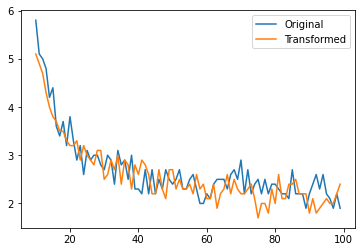

In [15]:
plt.plot(np.arange(100)[10:],acc1[10:],label='Original')
plt.plot(np.arange(100)[10:],acc2[10:],label='Transformed')
plt.legend()